In [2]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [3]:
!pip install lightGBM

In [4]:
import gc
gc.collect()

491

In [5]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
# 指定したディレクトリ配下のcsvデータをreadする
# is_denso = False
# train_year_list = ["2023", "2024"]
# train_path = '/home/hayato/horse_inference/data_for_train/train_data/2024/'
# if is_denso:
#     train_path = '/home/denso/horse_inference/data_for_train/train_data/2024/'

# # train dataを読み込み
# train_data = pd.read_csv(train_path + "train_data_results_2024_update.csv", encoding='utf-8')
# # データが多いと落ちるので半分だけ取得
# # train_data = train_data[:int(len(train_data)/2)]
# print("train data length {}".format(len(train_data)))

# # 勝率データ、過去のデータを取得
# horse_past_data = pd.read_csv(train_path + 'horse_results_2024.csv', encoding='utf-8')  
# # データが多いと落ちるので半分だけ取得
# # horse_past_data = horse_past_data[:int(len(horse_past_data)/2)]  
# print("horse_past_data length {}".format(len(horse_past_data)))
# horse_peds_data = pd.read_csv(train_path + 'horse_born_results_2024.csv', encoding='utf-8')
# # train_data = train_data[:100000]
# # horse_peds_data = horse_peds_data[:int(len(horse_peds_data)/2)]
# print("horse_peds_data length {}".format(len(horse_peds_data)))
# # ジョッキーの過去データを取得
# jockey_past_data = pd.read_csv(train_path + 'jockey_results_2024.csv', encoding='utf-8')
# # jockeyデータはデータの中で"累計"が含まれているものだけを抽出
# # "年度"列が"累計"の行だけを抽出
# jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']

In [6]:
inference_page_id = 2025050108

is_denso = True
# train_year_list = ["2024"]
train_year_list = ["2023", "2024"]
train_data = pd.DataFrame()
horse_past_data = pd.DataFrame()
horse_peds_data = pd.DataFrame()
jockey_past_data = pd.DataFrame()
for year in train_year_list:
    train_path = '/home/hayato/horse_inference/data_for_train/train_data/' + year + '/'
    if is_denso:
        train_path = '/home/denso/horse_inference/data_for_train/train_data/' + year + '/'
    # train dataに各年の学習データを縦方向に結合
    train_data = pd.concat([train_data, pd.read_csv(train_path + "train_data_results_" + year + ".csv", encoding='utf-8')], axis=0)
    print("train data length {}".format(len(train_data)))

    # 勝率データ、過去のデータを取得
    horse_past_data = pd.concat([horse_past_data, pd.read_csv(train_path + 'horse_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_past_data length {}".format(len(horse_past_data)))
    horse_peds_data = pd.concat([horse_peds_data, pd.read_csv(train_path + 'horse_born_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_peds_data length {}".format(len(horse_peds_data)))
    # ジョッキーの過去データを取得
    jockey_past_data = pd.concat([jockey_past_data, pd.read_csv(train_path + 'jockey_results_' + year + '.csv', encoding='utf-8')], axis=0)
    # jockeyデータはデータの中で"累計"が含まれているものだけを抽出
    # "年度"列が"累計"の行だけを抽出
    jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']
    print("jockey_past_data length {}".format(len(jockey_past_data)))

train data length 9371
horse_past_data length 99871
horse_peds_data length 4870
jockey_past_data length 161
train data length 54954
horse_past_data length 239645
horse_peds_data length 16430
jockey_past_data length 360


In [7]:
# horse_past_dataから最初のhorse_idの情報だけを抽出
first_horse_past_data = horse_past_data.drop_duplicates(subset='horse_id', keep='first')
# train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')

# train dataに対してhorse_past_data、horse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, first_horse_past_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54954 entries, 0 to 54953
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            54954 non-null  object 
 1   枠番            54954 non-null  int64  
 2   馬番            54954 non-null  int64  
 3   馬名            54954 non-null  object 
 4   性齢            54954 non-null  object 
 5   斤量            54954 non-null  float64
 6   騎手_x          54954 non-null  object 
 7   タイム_x         54450 non-null  object 
 8   着差_x          50420 non-null  object 
 9   単勝            54954 non-null  object 
 10  人気            54728 non-null  float64
 11  馬体重_x         54954 non-null  object 
 12  調教師           54954 non-null  object 
 13  course_len    54954 non-null  int64  
 14  weather       54954 non-null  object 
 15  race_type     54954 non-null  object 
 16  ground_state  54954 non-null  object 
 17  date          54954 non-null  object 
 18  horse_id      54954 non-nu

In [8]:
# horse_peds_dataはpeds62がhorse_idなので、peds62をhorse_idに変更
horse_peds_data = horse_peds_data.rename(columns={'peds_62': 'horse_id'})
# すごい馬の血糖情報があるけどそんなにいらないので、5頭分のpeds0からpeds5までの情報だけを取得
horse_peds_data = horse_peds_data[['horse_id', 'peds_0', 'peds_1', 'peds_2', 'peds_3', 'peds_4', 'peds_5']]
# 1pedsに色んな情報が入っているので、半角スペースまでの情報だけを取得
horse_peds_data['peds_0'] = horse_peds_data['peds_0'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_1'] = horse_peds_data['peds_1'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_2'] = horse_peds_data['peds_2'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_3'] = horse_peds_data['peds_3'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_4'] = horse_peds_data['peds_4'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_5'] = horse_peds_data['peds_5'].apply(lambda x: x.split(' ')[0])
# train dataに対してhorse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74219 entries, 0 to 74218
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            74219 non-null  object 
 1   枠番            74219 non-null  int64  
 2   馬番            74219 non-null  int64  
 3   馬名            74219 non-null  object 
 4   性齢            74219 non-null  object 
 5   斤量            74219 non-null  float64
 6   騎手_x          74219 non-null  object 
 7   タイム_x         73548 non-null  object 
 8   着差_x          68074 non-null  object 
 9   単勝            74219 non-null  object 
 10  人気            73920 non-null  float64
 11  馬体重_x         74219 non-null  object 
 12  調教師           74219 non-null  object 
 13  course_len    74219 non-null  int64  
 14  weather       74219 non-null  object 
 15  race_type     74219 non-null  object 
 16  ground_state  74219 non-null  object 
 17  date          74219 non-null  object 
 18  horse_id      74219 non-nu

In [9]:
# train_dataに対してjockey_past_dataをjockey_idをキーにして結合
# jockey_resultsから必要なjockey_idの情報だけを抽出
jockey_info = jockey_past_data[jockey_past_data['jockey_id'].isin(train_data['jockey_id'])]

train_data = pd.merge(train_data, jockey_info, on='jockey_id', how='left')
# train_data = pd.merge(train_data, jockey_past_data, on='jockey_id', how='left')
print(train_data.info())
# テスト的にtrain_dataのデータをcsvに保存
train_data.to_csv(train_path + "train_data_check.csv", index=False, encoding='utf-8')
print("train_data lenght :{}".format(len(train_data)))
train_data.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143779 entries, 0 to 143778
Data columns (total 66 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   着順            143779 non-null  object 
 1   枠番            143779 non-null  int64  
 2   馬番            143779 non-null  int64  
 3   馬名            143779 non-null  object 
 4   性齢            143779 non-null  object 
 5   斤量            143779 non-null  float64
 6   騎手_x          143779 non-null  object 
 7   タイム_x         142470 non-null  object 
 8   着差_x          131825 non-null  object 
 9   単勝            143779 non-null  object 
 10  人気            143191 non-null  float64
 11  馬体重_x         143779 non-null  object 
 12  調教師           143779 non-null  object 
 13  course_len    143779 non-null  int64  
 14  weather       143779 non-null  object 
 15  race_type     143779 non-null  object 
 16  ground_state  143779 non-null  object 
 17  date          143779 non-null  object 
 18  hors

,枠番,馬番,斤量,人気,course_len,horse_id,jockey_id,race_id,R,映 像,...,厩舎 ｺﾒﾝﾄ,備考,賞金,1着,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利
count,143779.000000,143779.000000,143779.000000,143191.000000,143779.000000,1.437790e+05,143779.000000,1.437790e+05,143572.000000,0.0,...,0.0,0.0,45316.000000,143779.000000,143779.000000,143779.000000,143779.000000,143779.000000,143779.000000,143779.000000
mean,4.781081,7.584585,55.773569,7.535865,1660.879405,2.020134e+09,1397.849470,2.023846e+11,7.750118,NaN,...,NaN,NaN,424.150770,574.243798,562.616189,551.237246,5327.032473,7015.129706,311.655833,23.558656
std,2.265411,4.338842,1.887463,4.315217,441.966806,1.343534e+06,1081.232094,4.194900e+07,3.229197,NaN,...,NaN,NaN,1442.235245,714.742604,614.676896,554.260757,4282.991671,5934.201054,399.283127,50.047847
min,1.000000,1.000000,49.000000,1.000000,1000.000000,2.012101e+09,422.000000,2.023010e+11,1.000000,NaN,...,NaN,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,3.000000,4.000000,55.000000,4.000000,1200.000000,2.019105e+09,1096.000000,2.024020e+11,6.000000,NaN,...,NaN,NaN,40.000000,108.000000,117.000000,130.000000,1882.000000,2199.000000,29.000000,0.000000
50%,5.000000,7.000000,56.000000,7.000000,1700.000000,2.020105e+09,1160.000000,2.024050e+11,8.000000,NaN,...,NaN,NaN,140.000000,312.000000,344.000000,351.000000,3732.000000,4790.000000,169.000000,7.000000
75%,7.000000,11.000000,57.000000,11.000000,1800.000000,2.021104e+09,1187.000000,2.024080e+11,10.000000,NaN,...,NaN,NaN,410.000000,803.000000,850.000000,910.000000,8786.000000,11616.000000,468.000000,23.000000
max,8.000000,18.000000,65.000000,18.000000,4250.000000,2.022110e+09,5667.000000,2.024100e+11,12.000000,NaN,...,NaN,NaN,50340.200000,4559.000000,3451.000000,2772.000000,18808.000000,24936.000000,2047.000000,363.000000


In [10]:
# train_dataの重複をrace_id, horse_idで削除
train_data = train_data.drop_duplicates(subset=["race_id", "horse_id"], keep='first')
# 重複をassertで確認
assert train_data.duplicated(subset=["race_id", "horse_id"]).sum() == 0

# oddsだけ前処理の前に準備しておく
train_data['単勝'] = train_data['単勝'].replace('---', 100)
train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))   
train_data_for_ranking = train_data.copy()


In [11]:

inference_data_path = "/home/hayato/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"
if is_denso:
    inference_data_path = "/home/denso/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"

In [12]:
train_data


,着順,枠番,馬番,馬名,性齢,斤量,騎手_x,タイム_x,着差_x,単勝,...,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利,勝率,連対率,複勝率,odds
0,1,5,5,サトミノキラリ,牡2,55.0,横山武史,1:09.5,NaN,1.2,...,556,543,3907,5667,274,23,11.7％,21.5％,31.1％,1.2
4,2,8,8,ベアゴーゴー,牝2,55.0,浜中俊,1:09.5,クビ,4.1,...,1161,1052,7817,11241,718,58,10.8％,21.1％,30.5％,4.1
8,3,6,6,ハピアーザンエバー,牡2,55.0,藤岡佑介,1:10.0,2.1/2,59.9,...,1050,1039,8818,11966,726,48,8.9％,17.6％,26.3％,59.9
12,4,4,4,デビルシズカチャン,牝2,55.0,ルメール,1:10.2,1.1/2,16.6,...,1411,1046,4546,8983,805,159,22.0％,37.7％,49.4％,16.6
16,5,1,1,ウィスピースノー,牝2,55.0,吉田隼人,1:10.3,1/2,23.9,...,1126,1040,10520,13875,546,28,8.6％,16.7％,24.2％,23.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143768,11,4,7,グランデスフィーダ,牡4,58.0,荻野極,1:46.6,2,32.3,...,212,240,3355,4033,119,2,5.6％,10.9％,16.8％,32.3
143770,12,6,10,アメリカンチーフ,牡3,54.0,西塚洸二,1:46.8,1.1/4,51.0,...,64,58,930,1122,9,0,6.2％,11.9％,17.1％,51.0
143772,13,5,8,シブースト,牝4,53.0,吉村誠之,1:49.0,大,167.0,...,36,43,496,613,4,0,6.2％,12.1％,19.1％,167.0
143773,14,8,15,ペイシャコパ,牝3,50.0,河原田菜,1:49.1,3/4,85.7,...,27,33,649,730,1,0,2.9％,6.6％,11.1％,85.7


In [13]:
train_data.info()
train_data_mlp = train_data.copy()


<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 143775
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            54954 non-null  object 
 1   枠番            54954 non-null  int64  
 2   馬番            54954 non-null  int64  
 3   馬名            54954 non-null  object 
 4   性齢            54954 non-null  object 
 5   斤量            54954 non-null  float64
 6   騎手_x          54954 non-null  object 
 7   タイム_x         54450 non-null  object 
 8   着差_x          50420 non-null  object 
 9   単勝            54954 non-null  object 
 10  人気            54728 non-null  float64
 11  馬体重_x         54954 non-null  object 
 12  調教師           54954 non-null  object 
 13  course_len    54954 non-null  int64  
 14  weather       54954 non-null  object 
 15  race_type     54954 non-null  object 
 16  ground_state  54954 non-null  object 
 17  date          54954 non-null  object 
 18  horse_id      54954 non-null  

In [14]:
# 前処理
def preprocess(train_data, is_ranking=False, is_mlp=False):
    # 不要な特長量であるUnnamed: 0、class_list_in_raceを削除する
    # train_data = train_data.drop(['馬名','騎手_x', '人気',"調教師","枠番"], axis=1)
    # これはlightGBMによる成約であり、0からクラス数-1の目的変数にラベリングしなければならない

    # 着順はobject型であるため、int型に変換する。"除"、"中"のような文字列だった場合は100に変換する
    train_data['着順'] = train_data['着順'].replace('除', 100).replace('中', 100).replace('取', 100).replace('計不', 100)
    # 着順が計不の場合は100に変換する
    train_data['着順'] = train_data['着順'].replace('計不', 100)
    # 着順列の値を処理して数値部分のみを抽出
    train_data['着順'] = train_data['着順'].apply(lambda x: int(x.split('(')[0]) if isinstance(x, str) else x)
    train_data['着順'] = train_data['着順'].astype(int)
    train_data['goal_number'] = train_data['着順']

    if not is_ranking:
        # ランキング学習でない場合は通常のグルーピング
        # 目的変数であるgoal_numberをグルーピングする。1であれば0、2と3は1にまとめる、4以上は2にまとめる
        train_data['goal_number'] = train_data['goal_number'].replace(
            {1: 0, 2: 1, 3: 1}
        ).apply(lambda x: 2 if x >= 4 else x)
    else:
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        # goal numberをスコア化
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        # ->評価指標(NDCG)に合わせて指数関数的にスコアをつける
        train_data['goal_number_replace'] = train_data['goal_number'].apply(
            # lambda x: 10 if x == 1 else (5 if x == 2 else (2 if x == 3 else 0)))
            lambda x: 10 if x == 1 else (3 if x == 2 else (1 if x == 3 else 0)))
    
    # inference に合わせて前処理を実施
    # 性齢の1文字から性別を取得しhorse_sexへ、2文字目以降から年齢を取得しhorse_ageへ格納する
    train_data['horse_sex'] = train_data['性齢'].apply(lambda x: x[0])
    train_data['horse_age'] = train_data['性齢'].apply(lambda x: int(x[1:]))
    # 馬体重_xから体重と、()内の増減を取得する
    # 馬体重が計不の場合は500
    train_data['馬体重_x'] = train_data['馬体重_x'].replace('計不', '500(0)')
    train_data['horse_weight'] = train_data['馬体重_x'].apply(lambda x: int(x.split('(')[0]))
    train_data['weight_change'] = train_data['馬体重_x'].apply(lambda x: int(x.split('(')[1].replace(')', '')))
    # 斤量を取得しhandiに格納する
    train_data['handi'] = train_data['斤量'].apply(lambda x: int(x))
    # course_lenを取得しdistanceに格納する
    train_data['distance'] = train_data['course_len'].apply(lambda x: int(x))
    # race_typeを取得し1文字目を取得しconditionに格納する
    train_data['condition'] = train_data['race_type'].apply(lambda x: x[0])
    # 馬番を取得しumabanに格納する
    train_data['umaban'] = train_data['馬番'].apply(lambda x: int(x))
    # 単勝を取得しoddsに格納する
    # 単勝が---の場合は100に変換する
    train_data['単勝'] = train_data['単勝'].replace('---', 100)
    train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))
    # oddsの逆数を取得し、odds_invに格納する
    train_data['odds_inv'] = train_data['odds'].apply(lambda x: 1 / x)

    # タイム_yは1:34.0のような形式なので、秒に変換する
    # nanの場合は100に変換する
    # 'タイム_y'列の値を文字列に変換し、NaN値を無視して処理を行う
    train_data['タイム_y'] = train_data['タイム_y'].astype(str).apply(
        lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if ':' in x else np.nan
    )

    # 'ペース'列の値を文字列に変換し、NaN値を無視して処理を行う
    train_data['pace1'] = train_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[0]) if '-' in x else np.nan
    )
    train_data['pace2'] = train_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[1]) if '-' in x else np.nan
    )

    # 馬体重_yは480(+2)のような形式なので、体重と増減を分ける
    train_data['馬体重_y'] = train_data['馬体重_y'].replace('計不', '500(0)')
    train_data['horse_weight_y'] = train_data['馬体重_y'].apply(lambda x: int(x.split('(')[0]))
    # 'weight_change_y'列を作成し、'馬体重_y'列の値を処理
    train_data['weight_change_y'] = train_data['馬体重_y'].apply(
        lambda x: int(x.split('(')[1].replace(')', '')) if '(' in x else np.nan
    )

    # '連対率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['連対率'] = train_data['連対率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['勝率'] = train_data['勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '複勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['複勝率'] = train_data['複勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # オッズの逆数を取得し、オッズの逆数に格納する
    train_data['1/オ ッ ズ'] = train_data['オ ッ ズ'].apply(lambda x: 1 / x)
    # columnの名前を確認し、:や 、"、'がある場合は_に置き換える
    # train_data.columns = train_data.columns.str.replace(":", "_")
    # train_data.columns = train_data.columns.str.replace(",", "_")
    # train_data.columns = train_data.columns.str.replace("'", "_")
    # train_data.columns = train_data.columns.str.replace('"', "_")
    # train_data.columns = train_data.columns.str.replace(" ", "_")

    # train dataのカラム情報を表示
    print(train_data.columns)

    # 学習、推論データの特長量を定義する
    target_feature = 'goal_number'
    features = [
        'distance',
        'condition',
        'umaban', # 100%になったし、そもそも不要なのでコメントアウト
        'horse_age',
        'horse_sex',
        # 'horse_weight', # 馬の体重は引っ張ってこれないのでコメントアウト
        # 'weight_change',
        'handi',
        # 'odds',
        "odds_inv",
        # ここまではtrain_resultとinferenceから抽出できる共通データ

        "weather",
        "ground_state", # 分類特長量

        # ここからは馬の過去データから抽出できるので必要な情報を追加する
        '天 気',
        '頭 数',
        '枠番',
        '馬番',
        # 'オ ッ ズ',
        '1/オ ッ ズ',
        '人気',
        # '着順', # 目的変数なので削除する
        '斤量',
        '距離',
        '馬 場',
        'タイム_y',
        'pace1',
        'pace2',
        '上り',
        'horse_weight_y',
        'weight_change_y',
        '賞金',
        # # ここからはジョッキーの過去データから抽出できるので必要な情報を追加する
        '1着',
        '2着',
        '3着',
        '4着〜',
        '騎乗 回数',
        '重賞 出走',
        '重賞 勝利',
        '勝率',
        '連対率',
        '複勝率',
        'peds_0',   # 血統情報を学習データに入れると結果が悪くなったのでコメントアウト
        'peds_1',
        'peds_2',
        'peds_3',
        'peds_4',
        'peds_5',
    ]
    if is_mlp:
        # race idを追加する
        features += ["race_id"]
        features += ["着順"]
    # 特長量を抽出する
    if is_ranking:
        additional_features = ['log_odds', 'normalized_odds', 'zscore_odds', 'odds_rank', 'odds_std','odds_diff-1-2',"odds_diff-1-3"]
        # additional_features = ['odds_std', "odds_diff-1-2","odds_diff-1-3"]
        # additinal_features = []
        train_data = train_data[features + [target_feature] + ['goal_number_replace'] + additional_features]
        # train_data = train_data[features + [target_feature] + ['goal_number_replace'] ]
    else:
        train_data = train_data[features + [target_feature]]
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = train_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        # object型は別のラベル名にてラベルエンコーディングする
        train_data[column] = le.fit_transform(train_data[column])
    # 学習データが大きすぎるので、train_dataの上から1000行を取得して学習データとする
    # if not is_ranking:
    #     train_data = train_data[:50000]
    print(train_data.info())
    return train_data

train_data = preprocess(train_data)
# mlp用にコピーする
train_data_mlp = preprocess(train_data_mlp, is_mlp=True)   


Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', 'peds_0', 'peds_1',
       'peds_2', 'peds_3', 'peds_4', 'peds_5', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'odds', 'goal_number',
       'horse_sex', 'horse_age', 'horse_weight', 'weight_change', 'handi',
       'distance', 'condition', 'umaban', 'odds_inv', 'pace1', 'pace2',
       'horse_weight_y', 'weight_change_y', '1/オ ッ ズ'],
      dtype='object')


/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 143775
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         54954 non-null  int64  
 1   condition        54954 non-null  int64  
 2   umaban           54954 non-null  int64  
 3   horse_age        54954 non-null  int64  
 4   horse_sex        54954 non-null  int64  
 5   handi            54954 non-null  int64  
 6   odds_inv         54954 non-null  float64
 7   weather          54954 non-null  int64  
 8   ground_state     54954 non-null  int64  
 9   天 気              54954 non-null  int64  
 10  頭 数              54947 non-null  float64
 11  枠番               54954 non-null  int64  
 12  馬番               54954 non-null  int64  
 13  1/オ ッ ズ          54420 non-null  float64
 14  人気               54728 non-null  float64
 15  斤量               54954 non-null  float64
 16  距離               54954 non-null  int64  
 17  馬 場             

/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [15]:
# 特長量の前処理①対数変換
def log_transform(train_data):
    # 対数変換を行う特長量を定義する。対象はスケールの大きいもの、右に裾が長いもの、指数的に増加するものがある。
    log_features = [
        # 'distance',
        'odds',
        'オ ッ ズ',
        # 'タイム_y',
        # '4着〜',
        # '騎乗 回数'
    ]
    # 対数変換を行う
    for feature in log_features:
        train_data[feature] = np.log1p(train_data[feature])
    return train_data

# train_data = log_transform(train_data)

In [16]:
# 特長量の前処理②標準化
def standard_scaler(train_data):
    # 標準化を行う特長量を定義する。標準化は特長量のスケールを揃えるために行う。ラベルエンコーディングされた特長量以外は基本実施
    standard_features = [
        'distance',
        # 'condition',
        # 'umaban', # 100%になったし、そもそも不要なのでコメントアウト
        # 'horse_age',
        # 'horse_sex',
        # 'horse_weight',
        # 'weight_change',
        'handi',
        # 'odds',
        # ここまではtrain_resultとinferenceから抽出できる共通データ

        # ここからは馬の過去データから抽出できるので必要な情報を追加する
        # '天 気',
        '頭 数',
        # '枠番',
        # '馬番',
        # 'オ ッ ズ',
        '人気',
        # '着順', # 目的変数なので削除する
        '斤量',
        # '距離',  # ラベルなので削除
        # '馬 場',
        'タイム_y',
        'pace1',
        'pace2',
        '上り',
        'horse_weight_y',
        'weight_change_y',
        '賞金',
        # # ここからはジョッキーの過去データから抽出できるので必要な情報を追加する
        '1着',
        '2着',
        '3着',
        '4着〜',
        '騎乗 回数',
        '重賞 出走',
        '重賞 勝利',
        '勝率',
        '連対率',
        '複勝率',
    ]
    # 標準化実施
    scaler = StandardScaler()
    train_data[standard_features] = scaler.fit_transform(train_data[standard_features])
    return train_data

train_data = standard_scaler(train_data)
    

/tmp/ipykernel_10982/2331473695.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[standard_features] = scaler.fit_transform(train_data[standard_features])


In [17]:
train_data.info()

# # train_dataの中からgoal_numberとついたすべての名前の特長量を削除する
# train_data = train_data.drop(train_data.filter(like='goal_number').columns, axis=1)

# #inference_dataも同様にgoal_numbearとついたすべての名前の特長量を削除する
# inference_data = inference_data.drop(inference_data.filter(like='goal_number').columns, axis=1)

<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 143775
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         54954 non-null  float64
 1   condition        54954 non-null  int64  
 2   umaban           54954 non-null  int64  
 3   horse_age        54954 non-null  int64  
 4   horse_sex        54954 non-null  int64  
 5   handi            54954 non-null  float64
 6   odds_inv         54954 non-null  float64
 7   weather          54954 non-null  int64  
 8   ground_state     54954 non-null  int64  
 9   天 気              54954 non-null  int64  
 10  頭 数              54947 non-null  float64
 11  枠番               54954 non-null  int64  
 12  馬番               54954 non-null  int64  
 13  1/オ ッ ズ          54420 non-null  float64
 14  人気               54728 non-null  float64
 15  斤量               54954 non-null  float64
 16  距離               54954 non-null  int64  
 17  馬 場             

In [18]:
# # train_dataの特長量のヒストグラムを表示する
# features = train_data.columns
# for feature in features:
#     plt.figure()
#     sns.histplot(train_data[feature])
#     # タイトルは日本語でも表示できるようにする
#     plt.title(feature)
#     plt.show()


In [19]:
# train_dataの

In [20]:
# train_dataを7:3でテストデータに分ける
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
train_total,test_total = train_test_split(train_data, test_size=0.3, random_state=42)

In [21]:
y = train_total['goal_number']
train_total.drop('goal_number', axis=1, inplace=True)

In [22]:
y_test_true = test_total['goal_number']
test_total.drop('goal_number', axis=1, inplace=True)

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)

train data length 30773
valid data length 7694
test data length 16487
train data length 30773
valid data length 7694
test data length 16487


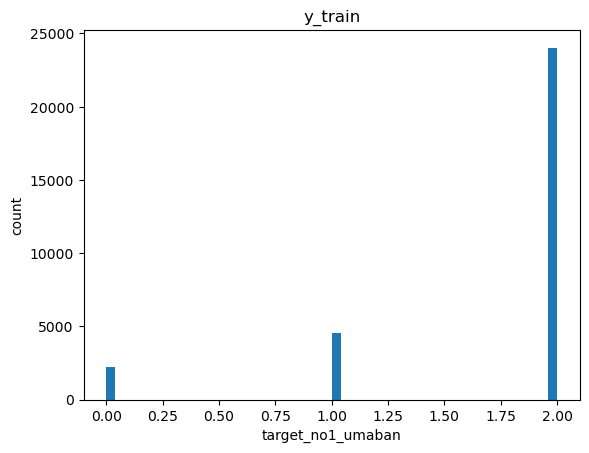

53220     1
60406     1
101286    2
84657     2
143686    2
         ..
68992     2
89698     1
36112     2
102274    2
108350    2
Name: goal_number, Length: 30773, dtype: int64


In [24]:
# 学習データ、検証データ、テストデータの割り振りが完了したので、それぞれのデータ数を表示する
print("train data length {}".format(len(X_train)))
print("valid data length {}".format(len(X_valid)))
print("test data length {}".format(len(test_total)))
# 回答データについても、同様にデータ数を表示する
print("train data length {}".format(len(y_train)))
print("valid data length {}".format(len(y_valid)))
print("test data length {}".format(len(y_test_true)))

# 回答データのヒストグラムを表示する
# 横軸をすべての番号で表示する
f, (ax) = plt.subplots()
ax.hist(y_train, bins=50)
ax.set_title('y_train')
ax.set_xlabel('target_no1_umaban')
ax.set_ylabel('count')

plt.show()

print(y_train)


In [25]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[2.2693954  2.2693954  0.42674488 ... 0.42674488 0.42674488 0.42674488]
[1. 1. 1. ... 1. 1. 1.]


In [26]:
# feature_names = dtrain.feature_name
# clean_feature_names = [name.replace(' ', '_').replace(':', '_').replace('"', '_').replace("'", '_') for name in feature_names]
# # データセットに新しい特徴量名を設定
# dtrain.feature_name = clean_feature_names
# dvalid.feature_name = clean_feature_names

In [27]:
learning_rate = 0.01
num_leaves = 15
max_depth = 12
min_data_in_leaf = 10
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    # 'metric': 'rmse',
    'metric': 'multi_logloss',
    # 'metric': 'auc', # AUCでもいい
    'num_class': 3, # クラスの数
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":100, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [28]:
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 100,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4678
[LightGBM] [Info] Number of data points in the train set: 30773, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.630934
[LightGBM] [Info] Start training from score -1.918126
[LightGBM] [Info] Start training from score -0.247043
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.530113	valid's multi_logloss: 0.5414


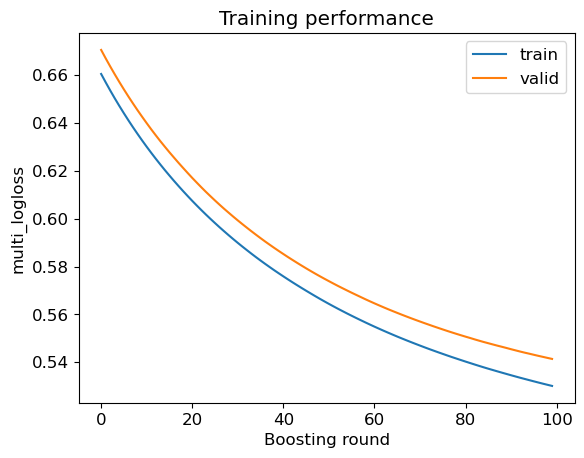

In [29]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [30]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

          0         1         2
0  0.083226  0.203477  0.713297
1  0.092949  0.175814  0.731236
2  0.064292  0.198423  0.737285
3  0.037168  0.087230  0.875602
4  0.052648  0.210549  0.736803
0       0.083226
1       0.092949
2       0.064292
3       0.037168
4       0.052648
          ...   
7689    0.059211
7690    0.395938
7691    0.195225
7692    0.036477
7693    0.298178
Name: 0, Length: 7694, dtype: float64


In [31]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0       2
1       2
2       2
3       2
4       2
       ..
7689    2
7690    0
7691    2
7692    2
7693    2
Length: 7694, dtype: int64

In [32]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(19)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)

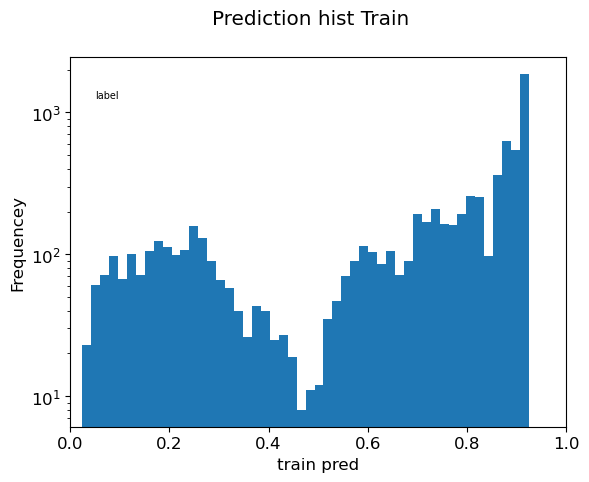

In [33]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

In [34]:
# for i, y_pred_category in enumerate(y_pred_categorical):
#     f, (ax) = plt.subplots()
#     f.suptitle('Prediction hist Train')

#     bins = 50

#     ax.hist(y_pred_category, bins = bins)

#     plt.xlabel('train pred')
#     plt.ylabel('Frequencey')
#     plt.xlim((0, 1))
#     plt.yscale('log')
#     plt.text(0.05, 0.9, 'labele is :{}'.format(i),transform = ax.transAxes, fontsize = 14)
#     plt.show();

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from current font.
  func(*args, **kwargs)
/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  func(*args, **kwargs)
/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  func(*args, **kwargs)
/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  func(*args, **kwargs)
/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26528 (\N{CJK UNIFIED IDEOGRAPH-67A0}) missing from current font.
  func(*args, 

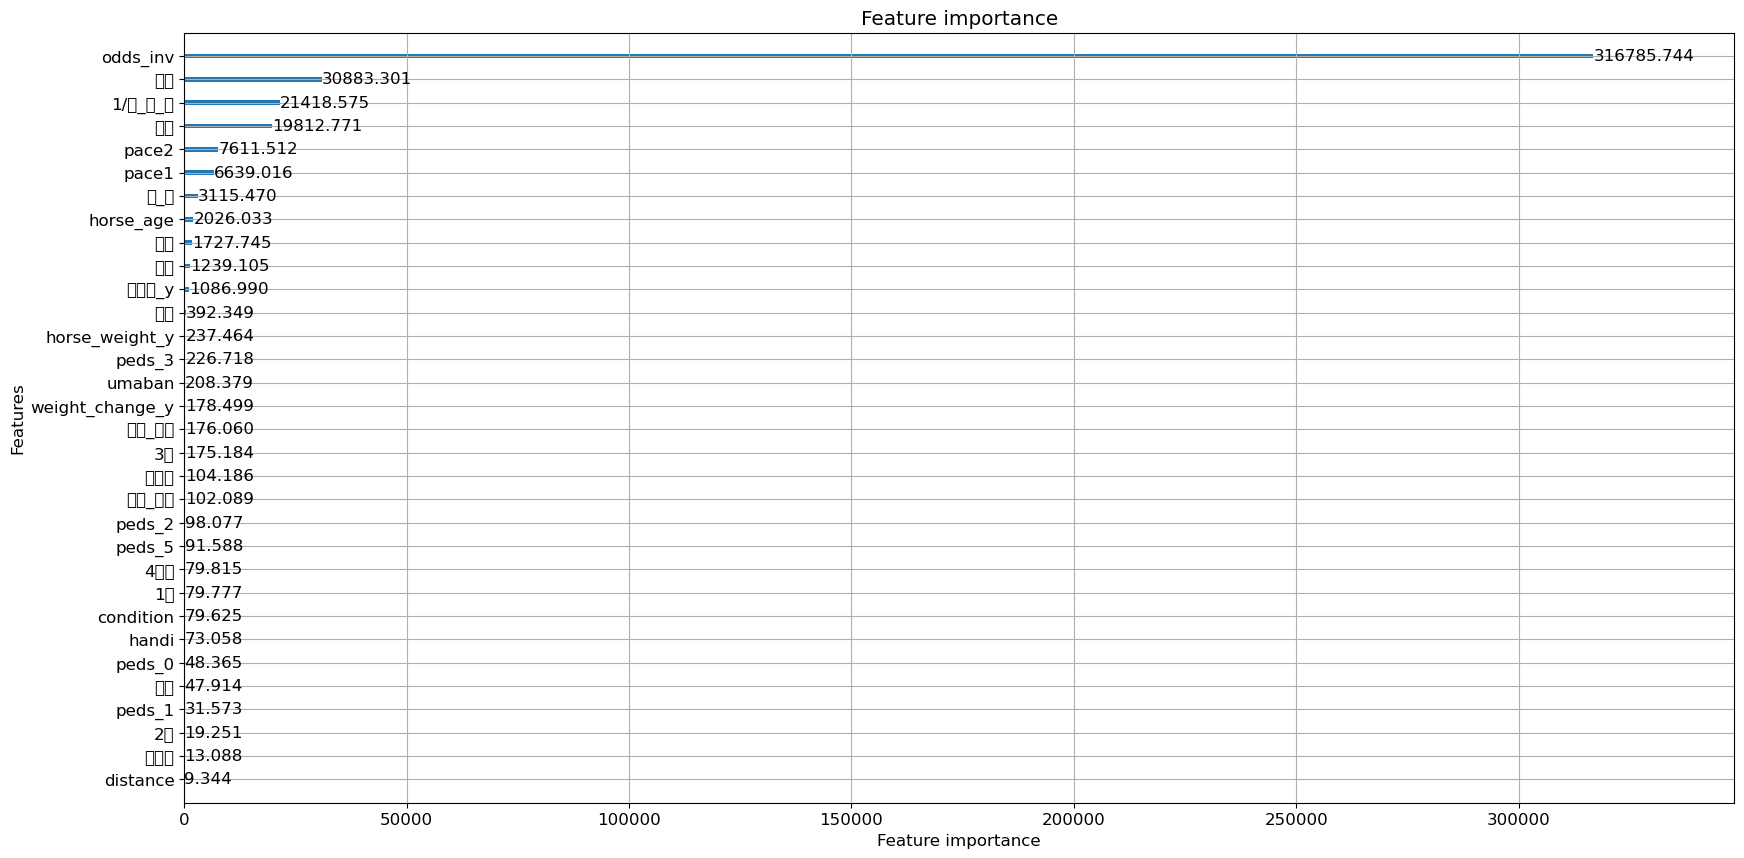

In [35]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

f1_score=0.7822978944632181


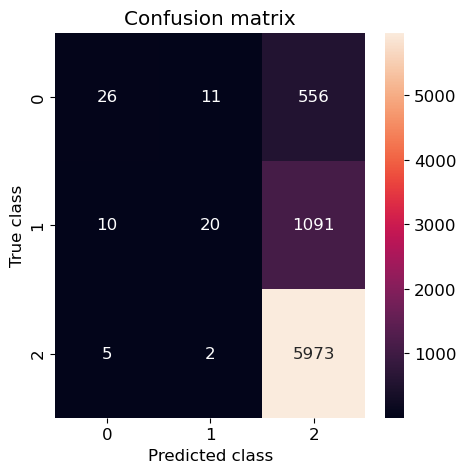

In [36]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

label = ["一位","二位か三位","四位以降"]

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

f1_score=0.7822978944632181


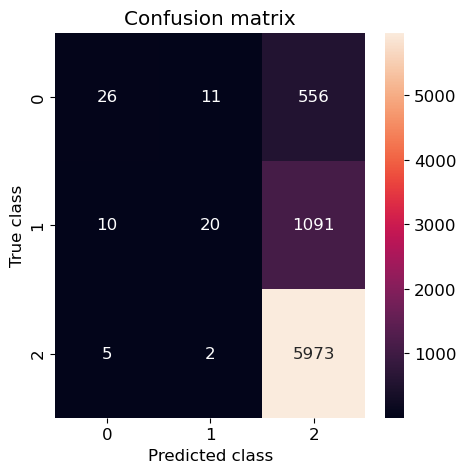

In [37]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

# y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
# y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


inference test data and compare with test correct data
              precision    recall  f1-score   support

           0       0.65      0.05      0.10      1229
           1       0.65      0.01      0.02      2422
           2       0.78      1.00      0.88     12836

    accuracy                           0.78     16487
   macro avg       0.70      0.35      0.33     16487
weighted avg       0.76      0.78      0.70     16487



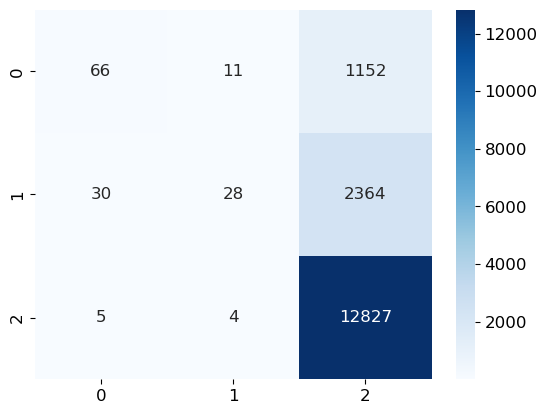

In [38]:
########### inference test data and compare with test correct data ###########
print("inference test data and compare with test correct data")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)

# テストデータの推論結果と、正解データを比較する
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_submit))
# confusion matrixを表示する
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_submit)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

# precisionが正解率。0と1のprecisionが高いと使い物になってくる。なぜなら高い順位の馬を推論できているから

In [39]:
train_data_for_ranking.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 143775
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            54954 non-null  object 
 1   枠番            54954 non-null  int64  
 2   馬番            54954 non-null  int64  
 3   馬名            54954 non-null  object 
 4   性齢            54954 non-null  object 
 5   斤量            54954 non-null  float64
 6   騎手_x          54954 non-null  object 
 7   タイム_x         54450 non-null  object 
 8   着差_x          50420 non-null  object 
 9   単勝            54954 non-null  object 
 10  人気            54728 non-null  float64
 11  馬体重_x         54954 non-null  object 
 12  調教師           54954 non-null  object 
 13  course_len    54954 non-null  int64  
 14  weather       54954 non-null  object 
 15  race_type     54954 non-null  object 
 16  ground_state  54954 non-null  object 
 17  date          54954 non-null  object 
 18  horse_id      54954 non-null  

In [40]:
def odds_feature_engineering(train_data_for_ranking):
    # クエリを使用してオッズの特長量をエンジニアリング
    # 1 オッズを対数変換
    train_data_for_ranking["log_odds"] = np.log1p(train_data_for_ranking["odds"])

    # 2 同一レースidにおけるオッズのmin-max正規化
    train_data_for_ranking["normalized_odds"] = (train_data_for_ranking["odds"] - train_data_for_ranking["odds"].min()) / (train_data_for_ranking["odds"].max() - train_data_for_ranking["odds"].min())
    # 3 zスコア標準化
    train_data_for_ranking["zscore_odds"] = (train_data_for_ranking["odds"] - train_data_for_ranking["odds"].mean()) / train_data_for_ranking["odds"].std()

    # 4オッズの順位
    train_data_for_ranking["odds_rank"] = train_data_for_ranking.groupby('race_id')['odds'].rank(ascending=True, method='min')

    # 5 レースごとのオッズのばらつき
    train_data_for_ranking["odds_std"] = train_data_for_ranking.groupby("race_id")["odds"].transform("std")
    return train_data_for_ranking

train_data_for_ranking = odds_feature_engineering(train_data_for_ranking)


In [41]:
# 各レースごとにオッズをソートして1位、2位、3位のオッズを取得
def get_odds_differences(df):
    odds_diff_1_2 = []
    odds_diff_1_3 = []
    for race_id, group in df.groupby('race_id'):
        sorted_group = group.sort_values('odds')
        if len(sorted_group) >= 3:
            odds_1 = sorted_group.iloc[0]['odds']
            odds_2 = sorted_group.iloc[1]['odds']
            odds_3 = sorted_group.iloc[2]['odds']
            odds_diff_1_2.extend([odds_1 - odds_2] * len(group))
            odds_diff_1_3.extend([odds_1 - odds_3] * len(group))
        else:
            odds_diff_1_2.extend([None] * len(group))
            odds_diff_1_3.extend([None] * len(group))
    return odds_diff_1_2, odds_diff_1_3

# オッズの差分を計算して新しい特徴量として追加
odds_diff_1_2, odds_diff_1_3 = get_odds_differences(train_data_for_ranking)
train_data_for_ranking['odds_diff-1-2'] = odds_diff_1_2
train_data_for_ranking['odds_diff-1-3'] = odds_diff_1_3

# 結果を確認
# print(train_data_for_ranking[['race_id', 'odds', 'odds_diff_1_2', 'odds_diff_1_3']].head())

In [42]:
# ランキング学習での推論
# step1 クエリを作成する
# ランキング学習のためのクエリを作成

# ============データ情報整理================
# X_train: 学習用データ。クエリ必要
# X_valid: 検証データ。クエリ必要
# y_train: 学習用データの答え
# y_valid: 検証データの答え
# test_total: テストデータ。クエリ不要
# y_test_true: テストデータの答え
# ========================================
# ランキング学習用のtrain dataを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_data_for_ranking[:int(len(train_data_for_ranking)*0.7)]
test_ranking = train_data_for_ranking[int(len(train_data_for_ranking)*0.7):]
test_ranking_race_id = test_ranking["race_id"]
# train_rankingを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_ranking[:int(len(train_ranking)*0.7)]
valid_ranking = train_ranking[int(len(train_ranking)*0.7):]

def create_query(df, name='train'):
    # データの先頭を表示して確認
    # print("DataFrame head:")
    # print(df.head())


    # groupbyを使用してdate, race_name, place, number_of_horses, distanceごとにカウント
    race_place_counts = df.groupby(['race_id']).size().reset_index(name='horse_count')

    # date列を昇順にソート
    # race_place_counts = race_place_counts.sort_values(by='date', ascending=False)

    # 各レースの馬の数をリストに保存
    horse_counts_list = race_place_counts['horse_count'].tolist()

    # 結果の表示
    print("\nResulting list of horse counts per race (sorted by date):")
    print(horse_counts_list)

    # 特徴量データを日付の古い順にソート
    # sorted_df = df.sort_values(by='date', ascending=True)

    # ソートデータの保存
    # df.to_csv("sorted_{}_data.csv".format(name), index=False)
    # date, race_name, place, number_of_horses, distanceのユニークな組み合わせを表示して確認
    print("\nUnique combinations of date, race_name, place, number_of_horses, distance:")
    # 上から100データを表示
    print(df[['course_len', 'weather', 'race_type', 'ground_state', 'date']].head(100))
    return horse_counts_list, df

# trainデータのクエリを作成
train_query, sorted_train_data = create_query(train_ranking,"train")
# validデータのクエリを作成
valid_query, sorted_valid_data = create_query(valid_ranking,"valid")





Resulting list of horse counts per race (sorted by date):
[8, 12, 14, 13, 10, 14, 16, 13, 9, 9, 15, 14, 8, 14, 16, 14, 6, 16, 12, 11, 10, 14, 16, 14, 9, 14, 15, 14, 14, 12, 15, 13, 14, 8, 16, 11, 14, 12, 14, 16, 12, 13, 13, 12, 14, 14, 14, 14, 14, 12, 16, 14, 10, 16, 13, 13, 9, 14, 14, 14, 14, 14, 15, 14, 7, 14, 12, 14, 11, 11, 14, 16, 9, 14, 12, 14, 13, 16, 12, 13, 9, 11, 14, 16, 7, 12, 14, 14, 10, 14, 14, 8, 11, 9, 15, 13, 12, 14, 16, 14, 11, 14, 16, 14, 14, 16, 14, 12, 11, 12, 13, 14, 9, 12, 16, 9, 14, 14, 15, 13, 11, 5, 12, 14, 13, 14, 14, 14, 14, 14, 14, 14, 9, 14, 12, 14, 5, 16, 12, 14, 16, 14, 16, 14, 8, 14, 16, 14, 13, 12, 16, 14, 16, 14, 10, 14, 11, 9, 14, 16, 14, 16, 14, 14, 14, 12, 14, 14, 16, 14, 12, 16, 11, 14, 9, 11, 8, 13, 13, 12, 16, 14, 12, 16, 11, 16, 11, 11, 16, 14, 16, 12, 16, 14, 11, 12, 14, 12, 14, 12, 11, 9, 15, 14, 14, 16, 12, 13, 11, 13, 12, 16, 11, 13, 16, 15, 10, 10, 16, 11, 5, 11, 11, 13, 8, 13, 16, 12, 16, 9, 12, 14, 6, 10, 9, 14, 13, 13, 13, 13, 9, 12, 12

In [43]:
# クエリの数の合計を確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
print("Total number of queries: {}".format(len(train_query) + len(valid_query)))
print("Number of rows in train data: {}".format(len(sorted_train_data)))
print("Number of rows in valid data: {}".format(len(sorted_valid_data)))
print("Total number of rows: {}".format(len(sorted_train_data) + len(sorted_valid_data)))


Number of queries in train data: 26926
Number of queries in valid data: 8078
Total number of queries: 2566
Number of rows in train data: 26926
Number of rows in valid data: 8078
Total number of rows: 35004


In [44]:
# クエリを取得したので前処理をかける
X_sorted_train_data = preprocess(sorted_train_data,is_ranking=True)
X_sorted_valid_data = preprocess(sorted_valid_data,is_ranking=True)
test_ranking = preprocess(test_ranking,is_ranking=True)

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', 'peds_0', 'peds_1',
       'peds_2', 'peds_3', 'peds_4', 'peds_5', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'odds', 'log_odds',
       'normalized_odds', 'zscore_odds', 'odds_rank', 'odds_std',
       'odds_diff-1-2', 'odds_diff-1-3', 'goal_number', 'goal_number_replace',
       'horse_sex', 'horse_age', 'horse_weight', 'weight_change', 'handi',
       'distance', 'condition', 'umaban', 'odds_inv', 'pace1', 'pace2',
       'horse_weight_y', 'weight_change_y', '1/オ ッ ズ'],
      dtype='object')
<class 'pandas.cor

/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', 'peds_0', 'peds_1',
       'peds_2', 'peds_3', 'peds_4', 'peds_5', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'odds', 'log_odds',
       'normalized_odds', 'zscore_odds', 'odds_rank', 'odds_std',
       'odds_diff-1-2', 'odds_diff-1-3', 'goal_number', 'goal_number_replace',
       'horse_sex', 'horse_age', 'horse_weight', 'weight_change', 'handi',
       'distance', 'condition', 'umaban', 'odds_inv', 'pace1', 'pace2',
       'horse_weight_y', 'weight_change_y', '1/オ ッ ズ'],
      dtype='object')
<class 'pandas.cor

/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_10982/387848698.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', 'peds_0', 'peds_1',
       'peds_2', 'peds_3', 'peds_4', 'peds_5', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'odds', 'log_odds',
       'normalized_odds', 'zscore_odds', 'odds_rank', 'odds_std',
       'odds_diff-1-2', 'odds_diff-1-3', 'goal_number', 'goal_number_replace',
       'horse_sex', 'horse_age', 'horse_weight', 'weight_change', 'handi',
       'distance', 'condition', 'umaban', 'odds_inv', 'pace1', 'pace2',
       'horse_weight_y', 'weight_change_y', '1/オ ッ ズ'],
      dtype='object')
<class 'pandas.cor

/tmp/ipykernel_10982/387848698.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['連対率'] = train_data['連対率'].apply(
/tmp/ipykernel_10982/387848698.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['勝率'] = train_data['勝率'].apply(
/tmp/ipykernel_10982/387848698.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [45]:
# うまく目的変数の変換ができないので、現状のデータを見てみる
# X_sorted_train_data.to_csv("X_sorted_train_data.csv", index=False)

In [46]:
# X_sorted_train_dataにgoal_number_replaceを追加してcsvに保存する
# X_sorted_train_data.to_csv("X_sorted_train_data_add_goal_number.csv", index=False)

In [47]:
# 1. 目的変数goal_number_replaceを確保
# 2. 実際のgoal_numberを確保
# 3. goal_number_replaceを削除
# 4. goal_numberを削除
# 1========================================================
y_train_ranking = X_sorted_train_data['goal_number_replace']
y_valid_ranking = X_sorted_valid_data['goal_number_replace']
y_test_true_ranking = test_ranking['goal_number_replace']
# 2========================================================
y_train_ranking_goal = X_sorted_train_data['goal_number']
y_valid_ranking_goal = X_sorted_valid_data['goal_number']
y_test_true_ranking_goal = test_ranking['goal_number']
# 3========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number', axis=1)
test_ranking = test_ranking.drop('goal_number', axis=1)
# 4========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number_replace', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number_replace', axis=1)
test_ranking = test_ranking.drop('goal_number_replace', axis=1)


In [48]:
# 学習データ
X_sorted_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26926 entries, 0 to 74478
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         26926 non-null  int64  
 1   condition        26926 non-null  int64  
 2   umaban           26926 non-null  int64  
 3   horse_age        26926 non-null  int64  
 4   horse_sex        26926 non-null  int64  
 5   handi            26926 non-null  int64  
 6   odds_inv         26926 non-null  float64
 7   weather          26926 non-null  int64  
 8   ground_state     26926 non-null  int64  
 9   天 気              26926 non-null  int64  
 10  頭 数              26923 non-null  float64
 11  枠番               26926 non-null  int64  
 12  馬番               26926 non-null  int64  
 13  1/オ ッ ズ          26622 non-null  float64
 14  人気               26818 non-null  float64
 15  斤量               26926 non-null  float64
 16  距離               26926 non-null  int64  
 17  馬 場              

In [49]:
test_ranking.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16487 entries, 103055 to 143775
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         16487 non-null  int64  
 1   condition        16487 non-null  int64  
 2   umaban           16487 non-null  int64  
 3   horse_age        16487 non-null  int64  
 4   horse_sex        16487 non-null  int64  
 5   handi            16487 non-null  int64  
 6   odds_inv         16487 non-null  float64
 7   weather          16487 non-null  int64  
 8   ground_state     16487 non-null  int64  
 9   天 気              16487 non-null  int64  
 10  頭 数              16485 non-null  float64
 11  枠番               16487 non-null  int64  
 12  馬番               16487 non-null  int64  
 13  1/オ ッ ズ          16362 non-null  float64
 14  人気               16416 non-null  float64
 15  斤量               16487 non-null  float64
 16  距離               16487 non-null  int64  
 17  馬 場        

In [50]:
# クエリの合計とデータの合計が一致しているか確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
# y_train_rankingの数とX_sorted_train_dataの数が一致しているか確認
print("y_train_ranking length {}".format(len(y_train_ranking)))
print("Number of rows in train data: {}".format(len(X_sorted_train_data)))
print("Number of rows in valid data: {}".format(len(X_sorted_valid_data)))
print("Total number of rows: {}".format(len(X_sorted_train_data) + len(X_sorted_valid_data)))

Number of queries in train data: 26926
Number of queries in valid data: 8078
y_train_ranking length 26926
Number of rows in train data: 26926
Number of rows in valid data: 8078
Total number of rows: 35004


In [51]:
# スクレイピングするごとにカラム名が変化してくので、カラム名のスペースを削除する処理を学習前に追加
# X_sorted_train_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace(' ', '')
X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace('　', '')

# X_sorted_valid_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_valid_data.columns = X_sorted_valid_data.columns.str.replace(' ', '')
X_sorted_valid_data.columns = X_sorted_valid_data.columns.str.replace('　', '')

# test_ranking.columnsの日本語文字列の半角、全角スペースを削除する
test_ranking.columns = test_ranking.columns.str.replace(' ', '')
test_ranking.columns = test_ranking.columns.str.replace('　', '')



In [52]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.metrics import ndcg_score

# データの準備
# X_sorted_train_data, y_train_ranking, train_query
# X_sorted_valid_data, y_valid_ranking, valid_query

# ランキング学習
model = lgb.LGBMRanker(
    random_state=42,
    objective='lambdarank',
    metric='ndcg',
    n_estimators=500,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    num_leaves=10,                 # 決定木にある分岐の個数(default:31)
    max_depth=10,                  # 決定木の深さの最大値(default:-1)
    min_child_samples=40,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # feature_fraction=0.8,
    # bagging_fraction=0.8,
    # bagging_freq=10,
    # lambda_l1=0.1,
    # lambda_l2=0.1,
    # min_split_gain=0.1,
    # min_child_weight=0.1
    # rambdalank_truncation_level=10,
    max_position=3, # 3位までの順位を予測する,
    # lambdarank_truncation_level = 5,
)

# モデルの学習
model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    eval_at=[1, 2, 3],
    eval_metric='ndcg',
)

[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5892
[LightGBM] [Info] Number of data points in the train set: 26926, number of used features: 48
[LightGBM] [Warning] Unknown parameter: max_position


LGBMRanker(max_depth=10, max_position=3, metric='ndcg', min_child_samples=40,
           n_estimators=500, num_leaves=10, objective='lambdarank',
           random_state=42)

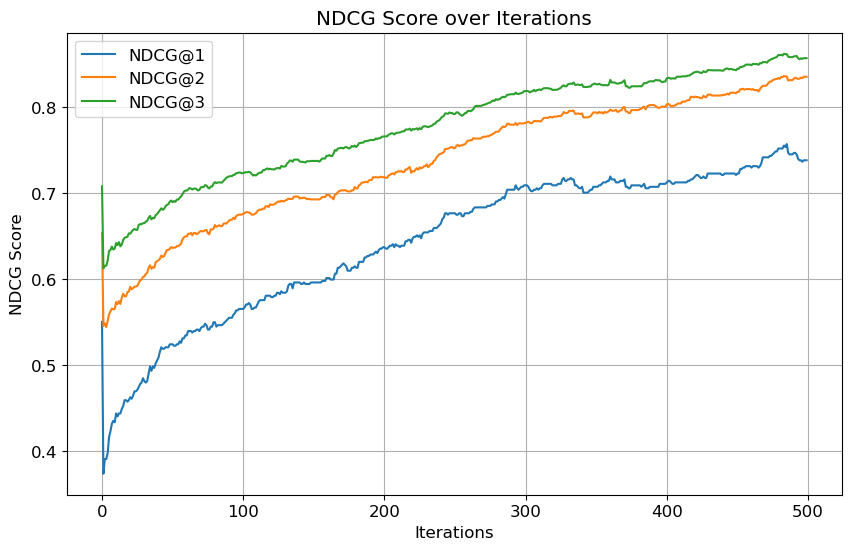

Best NDCG@1: 0.7382 in iteration: 0
Best NDCG@2: 0.8353 in iteration: 0
Best NDCG@3: 0.8569 in iteration: 0


In [53]:
# トレーニング結果の取得
evals_result = model.evals_result_

# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evals_result['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evals_result['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@1'][model.best_iteration_ - 1], model.best_iteration_))
print("Best NDCG@2: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@2'][model.best_iteration_ - 1], model.best_iteration_))
print("Best NDCG@3: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@3'][model.best_iteration_ - 1], model.best_iteration_))

In [54]:
# アンサンブル候補①LightGBM(RankNet)
# 学習データ： X_sorted_train_data, y_train_ranking
# 学習データのクエリ： train_query
# 検証データ： X_sorted_valid_data, y_valid_ranking
# 検証データのクエリ： valid_query
# テストデータ： test_ranking, y_test_true_ranking

# LightGBMデータセット
train_data = lgb.Dataset(X_sorted_train_data, label=y_train_ranking, group=train_query)
valid_data = lgb.Dataset(X_sorted_valid_data, label=y_valid_ranking, group=valid_query)
# パラメータの設定
params = {
    'objective': 'rank_xendcg',
    'metric': 'ndcg',
    'ndcg_at': [1, 2, 3],
    'n_estimators':1000,              # 決定木の個数(default:100) 5000のほうが10000より高い
    'learning_rate':0.1,            # 学習率(default:0.1)
    'num_leaves':10,                 # 決定木にある分岐の個数(default:31)
    'max_depth':10,                  # 決定木の深さの最大値(default:-1)
    "max_position":3, # 3位までの順位を予測する
    "min_data_in_leaf":40,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # "lambdarank_truncation_level":5,
}

evaluation_results = {}
# モデルの学習
ranknet_model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[lgb.record_evaluation(evaluation_results)],
)


[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5892
[LightGBM] [Info] Number of data points in the train set: 26926, number of used features: 48
[LightGBM] [Warning] Unknown parameter: max_position


/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


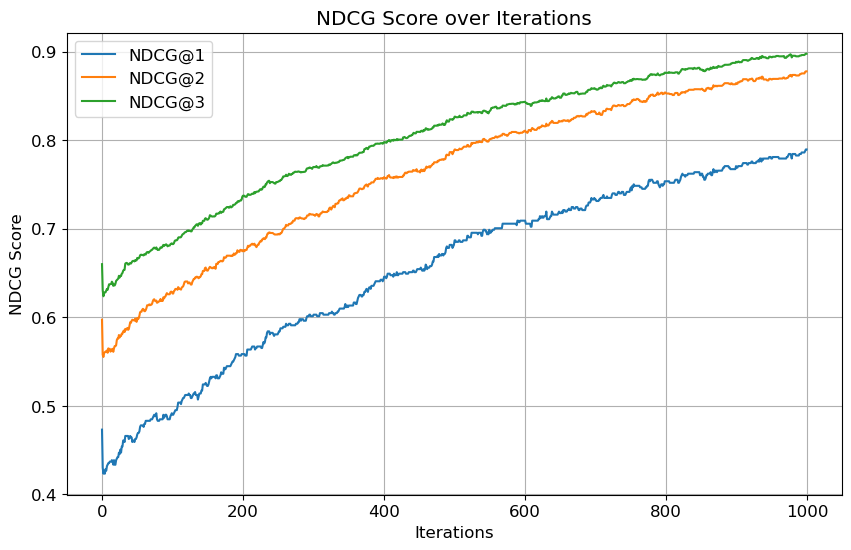

Best NDCG@1: 0.7896 in iteration: 0
Best NDCG@2: 0.8778 in iteration: 0
Best NDCG@3: 0.8977 in iteration: 0


In [55]:

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evaluation_results['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evaluation_results['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evaluation_results['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@1'], ranknet_model.best_iteration))
# 2も出力
print("Best NDCG@2: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@2'], ranknet_model.best_iteration))
# 3も出力
print("Best NDCG@3: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@3'], ranknet_model.best_iteration))


/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [17:16:41] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/learner.cc:742: 
Parameters: { "max_position", "min_child_samples" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-ndcg:0.72828
[100]	validation_0-ndcg:0.91779
[200]	validation_0-ndcg:0.94519
[300]	validation_0-ndcg:0.95011
[400]	validation_0-ndcg:0.95697
[500]	validation_0-ndcg:0.96165
[600]	validation_0-ndcg:0.96564
[700]	validation_0-ndcg:0.96587
[765]	validation_0-ndcg:0.96672


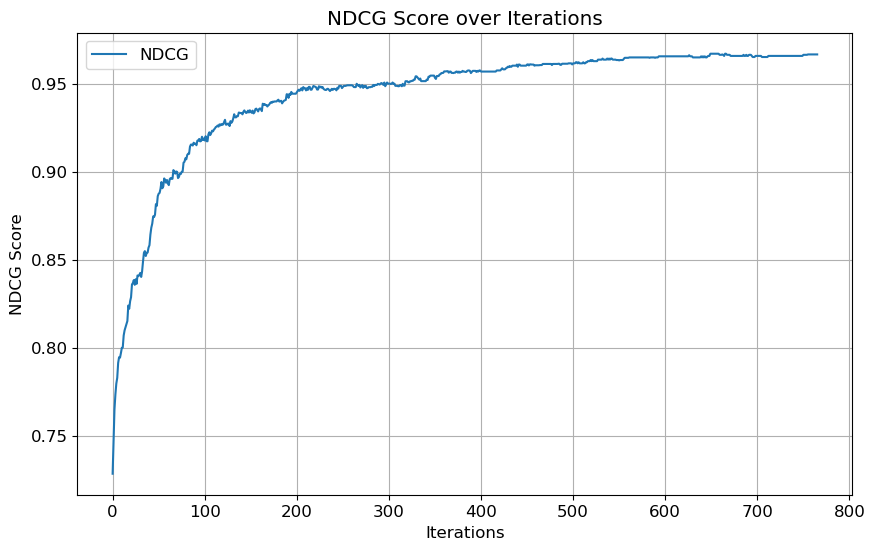

Best NDCG: 0.9671 in iteration: 665


In [56]:
# アンサンブル候補②XGBoost(Pairwise)
from xgboost import XGBRanker
# モデルの定義
pairwise_model = XGBRanker(
    objective='rank:pairwise',
    eval_metric='ndcg',
    n_estimators=1000,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    max_depth=10,                    # 決定木の深さの最大値(default:6)
    # subsample=0.8,                  # データのサンプリング比率(default:1)
    # colsample_bytree=0.8,           # 列のサンプリング比率(default:1)
    # min_child_weight=0.5,           # 葉の重みの最小値(default:1)
    # reg_lambda=1.0,                 # L2正則化の強さ(default:1)
    # gamma=0.1,                      # 葉の追加分岐を行うかの閾値(default:0)
    # n_jobs=-1,                      # 並列処理の数(default:1)
    random_state=42,                # 乱数のシード値(default:0)
    max_position=3, # 3位までの順位を予測する
    min_child_samples=30,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # lambdarank_truncation_level=5,
)
# モデルの学習
pairwise_model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    verbose=100,
    early_stopping_rounds=100,
)

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(pairwise_model.evals_result()['validation_0']['ndcg'], label='NDCG')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG: {:.4f} in iteration: {}".format(pairwise_model.best_score, pairwise_model.best_iteration))

[LightGBM] [Warning] Unknown parameter: max_position


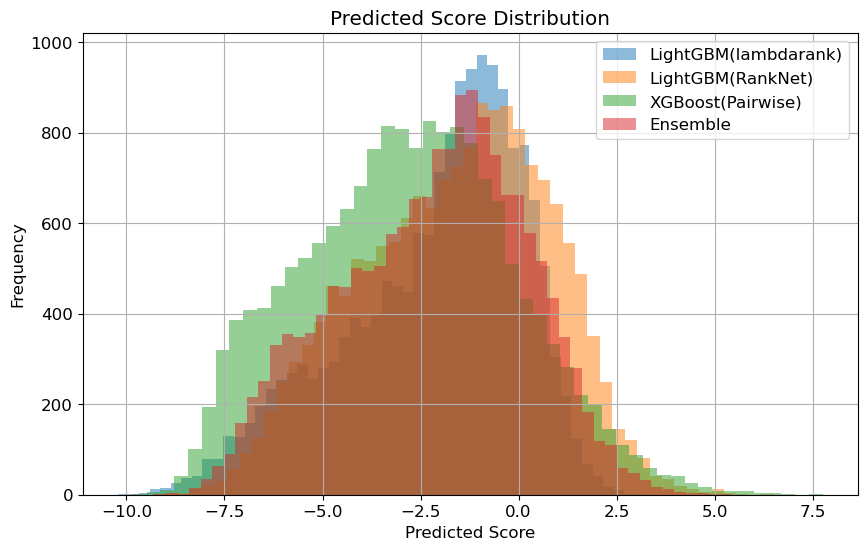

In [57]:
#　テストデータで推論
# LighGBM(lambdarank)の推論
prediction_test_ranking = model.predict(test_ranking, num_iteration=model.best_iteration_)
# LightGBM(RankNet)の推論
prediction_test_ranking_ranknet = ranknet_model.predict(test_ranking)
# XGBoost(Pairwise)の推論
prediction_test_ranking_pairwise = pairwise_model.predict(test_ranking)
# 上記の平均をアンサンブルモデルとする
prediction_test_ranking_ensemble = (prediction_test_ranking + prediction_test_ranking_ranknet + prediction_test_ranking_pairwise) / 3

df_prediction_test_ranking = pd.DataFrame({
    "馬番号": test_ranking["umaban"],
    "予測スコア(lambdarank)": prediction_test_ranking,
    "予測スコア(RankNet)": prediction_test_ranking_ranknet,
    "予測スコア(Pairwise)": prediction_test_ranking_pairwise,
    "ensemble_prediction": prediction_test_ranking_ensemble,
    "着順関連度": y_test_true_ranking,
    "着順": y_test_true_ranking_goal,
    "race_id": test_ranking_race_id,
    "distance": test_ranking["distance"],
    "ground_state": test_ranking["ground_state"],
    "weather": test_ranking["weather"],
    "condition": test_ranking["condition"],
})


# 同じレースidのうちスコアの大きい順に1位から予測順位を計算する
df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(lambdarank)"].rank(ascending=False, method='first')
df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(RankNet)"].rank(ascending=False, method='first')
df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(Pairwise)"].rank(ascending=False, method='first')
df_prediction_test_ranking["ensemble_prediction_rank"] = df_prediction_test_ranking.groupby("race_id")["ensemble_prediction"].rank(ascending=False, method='first')
# それぞれの予測順位はfloat型なのでint型に変換
df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking["予測順位(lambdarank)"].astype(int)
df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking["予測順位(RankNet)"].astype(int)
df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking["予測順位(Pairwise)"].astype(int)
df_prediction_test_ranking["ensemble_prediction_rank"] = df_prediction_test_ranking["ensemble_prediction_rank"].astype(int)

# 3つのモデルがすべて1位と判断したときだけ1位とするアンサンブルモデル
# df_prediction_test_ranking['ensemble_prediction'] = (
#     (df_prediction_test_ranking['予測順位(lambdarank)'] == 1) &
#     (df_prediction_test_ranking['予測順位(RankNet)'] == 1) &
#     (df_prediction_test_ranking['予測順位(Pairwise)'] == 1)
# ).astype(int)

# 予測スコアの分布を可視化
plt.figure(figsize=(10, 6))
plt.hist(prediction_test_ranking, bins=50, alpha=0.5, label='LightGBM(lambdarank)')
plt.hist(prediction_test_ranking_ranknet, bins=50, alpha=0.5, label='LightGBM(RankNet)')
plt.hist(prediction_test_ranking_pairwise, bins=50, alpha=0.5, label='XGBoost(Pairwise)')
plt.hist(prediction_test_ranking_ensemble, bins=50, alpha=0.5, label='Ensemble')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.title('Predicted Score Distribution')
plt.legend()
plt.grid(True)
plt.show()



LightGBM(lambdarank)の評価
True Positive: 470
False Positive: 755
False Negative: 757
True Negative: 14505
Precision: 0.3837
Recall: 0.3830
F1 Score: 0.3834


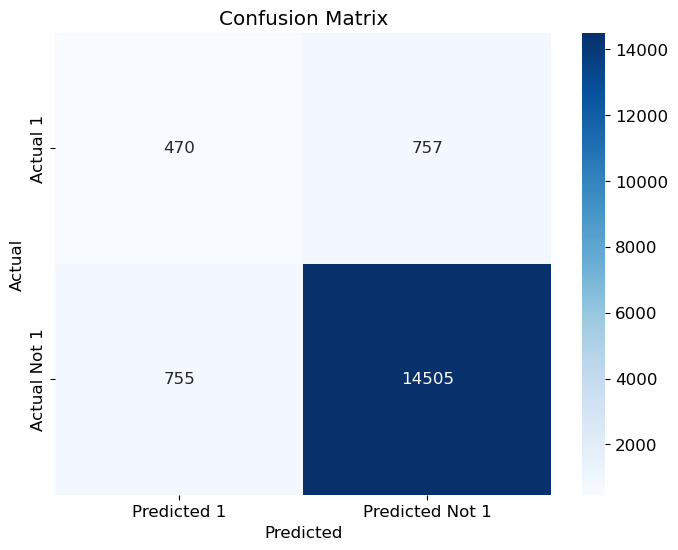

LightGBM(RankNet)の評価
True Positive: 495
False Positive: 730
False Negative: 732
True Negative: 14530
Precision: 0.4041
Recall: 0.4034
F1 Score: 0.4038


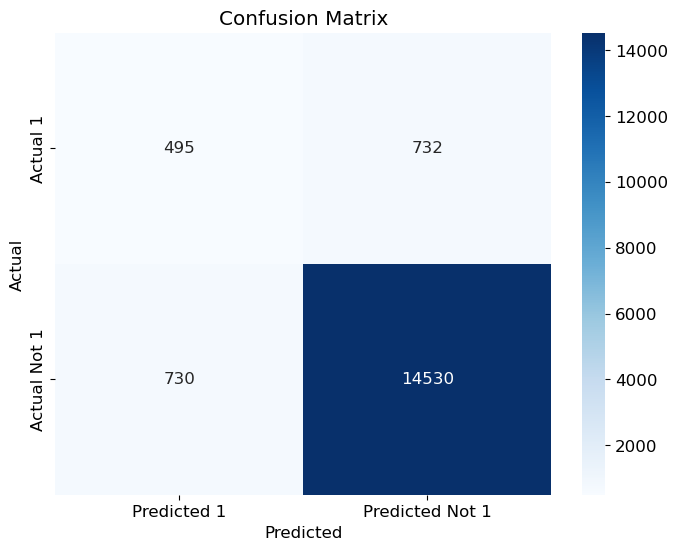

XGBoost(Pairwise)の評価
True Positive: 458
False Positive: 767
False Negative: 769
True Negative: 14493
Precision: 0.3739
Recall: 0.3733
F1 Score: 0.3736


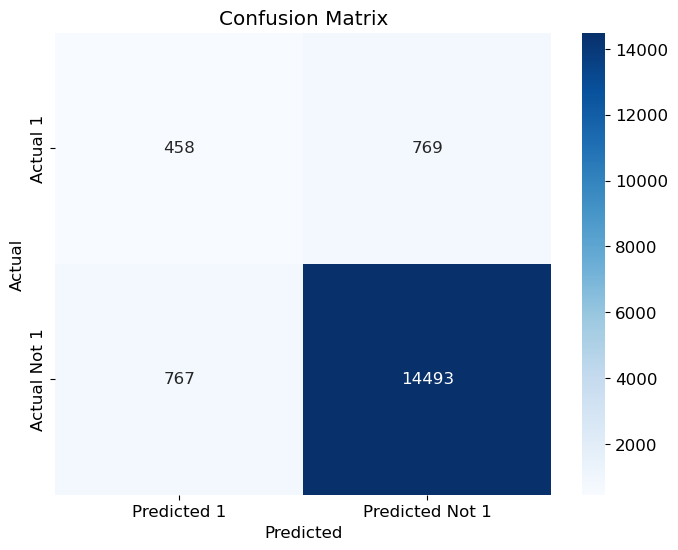

アンサンブルモデルの評価
True Positive: 492
False Positive: 733
False Negative: 735
True Negative: 14527
Precision: 0.4016
Recall: 0.4010
F1 Score: 0.4013


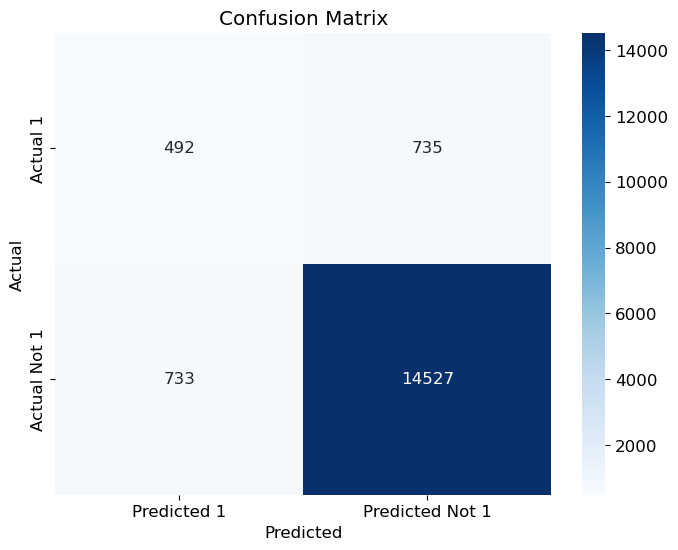

In [58]:
# 予測結果の評価
def rank_evaluation(modelname='予測順位(lambdarank)'):


    # 1位予想で1位だった数
    true_positive = df_prediction_test_ranking[
        (df_prediction_test_ranking[modelname] == 1) & 
        (df_prediction_test_ranking['着順'] == 1)
    ].shape[0]

    # 1位予想で1位じゃなかった数
    false_positive = df_prediction_test_ranking[
        (df_prediction_test_ranking[modelname] == 1) & 
        (df_prediction_test_ranking['着順'] != 1)
    ].shape[0]

    # 1位じゃない予想で1位だった数
    false_negative = df_prediction_test_ranking[
        (df_prediction_test_ranking[modelname] != 1) & 
        (df_prediction_test_ranking['着順'] == 1)
    ].shape[0]

    # 1位じゃない予想で1位じゃなかった数
    true_negative = df_prediction_test_ranking[
        (df_prediction_test_ranking[modelname] != 1) & 
        (df_prediction_test_ranking['着順'] != 1)
    ].shape[0]

    print(f'True Positive: {true_positive}')
    print(f'False Positive: {false_positive}')
    print(f'False Negative: {false_negative}')
    print(f'True Negative: {true_negative}')
    # presicion, recall, f1 scoreの計算
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion Matrixの作成
    confusion_matrix = np.array([[true_positive, false_negative],
                                [false_positive, true_negative]])

    # Confusion Matrixの可視化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 1', 'Predicted Not 1'], yticklabels=['Actual 1', 'Actual Not 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

print("LightGBM(lambdarank)の評価")
rank_evaluation('予測順位(lambdarank)')
print("LightGBM(RankNet)の評価")
rank_evaluation('予測順位(RankNet)')
print("XGBoost(Pairwise)の評価")
rank_evaluation('予測順位(Pairwise)')
print("アンサンブルモデルの評価")
rank_evaluation('ensemble_prediction_rank')

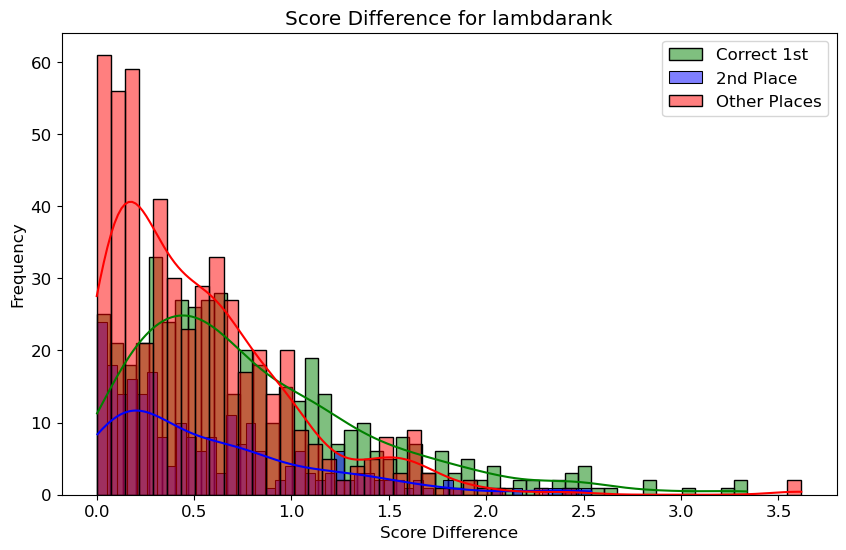

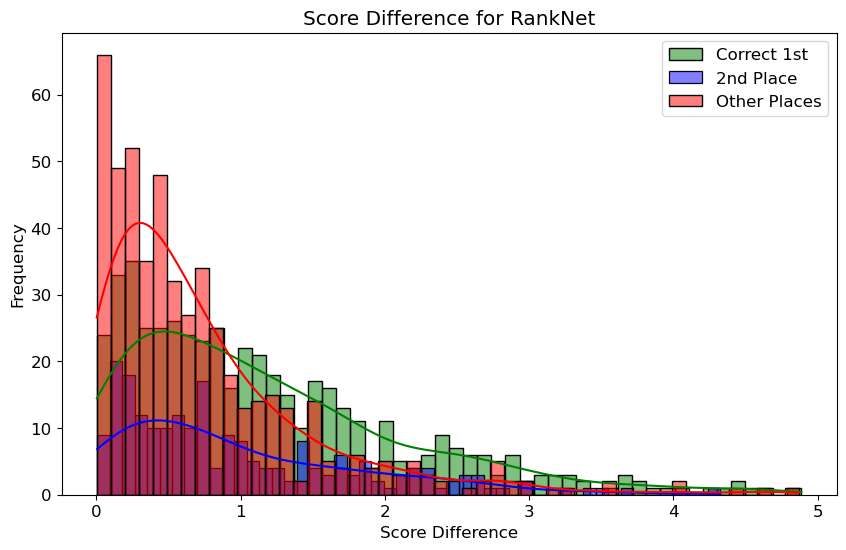

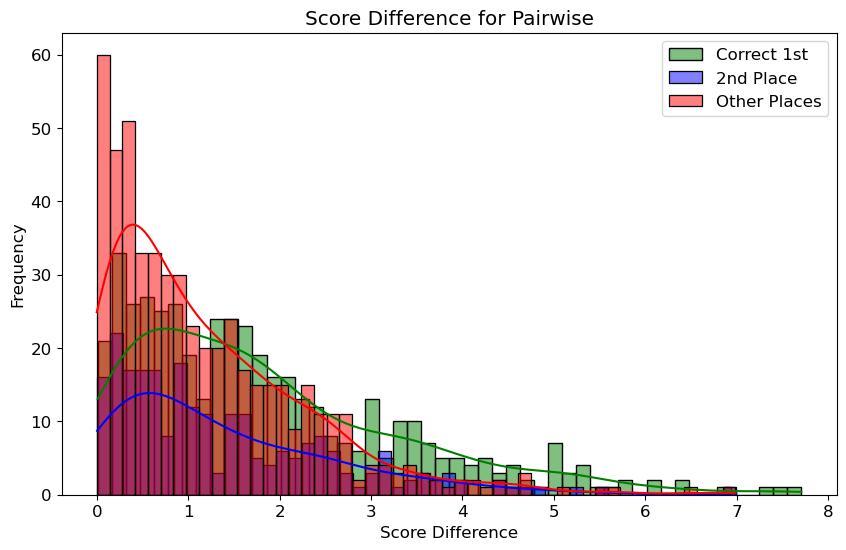

Optimal Threshold (ROC) for lambdarank: 0.5624515718329617
Optimal Threshold (Precision-Recall) for lambdarank: 0.02319452149160217
Optimal Threshold (ROC) for RankNet: 0.988299640699317
Optimal Threshold (Precision-Recall) for RankNet: 0.010294654703577155
Optimal Threshold (ROC) for Pairwise: 2.0724768340587616
Optimal Threshold (Precision-Recall) for Pairwise: 4.410743713378906e-05
Precision for lambdarank: 0.4647
Recall for lambdarank: 0.2143
F1 Score for lambdarank: 0.2934


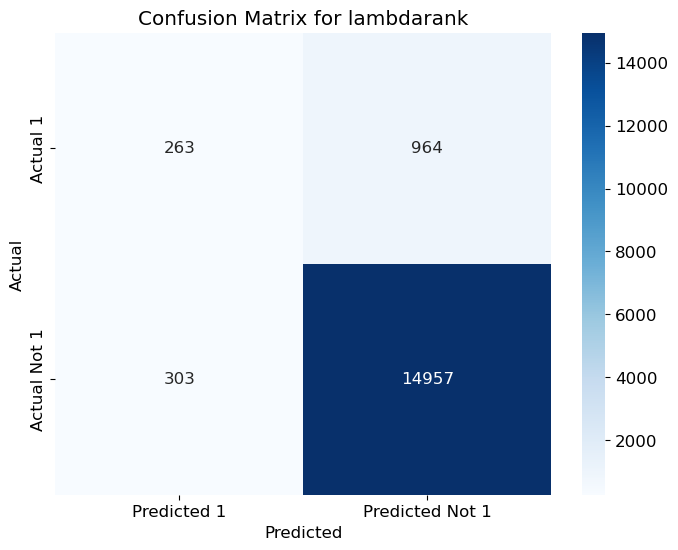

Precision for RankNet: 0.5324
Recall for RankNet: 0.1940
F1 Score for RankNet: 0.2843


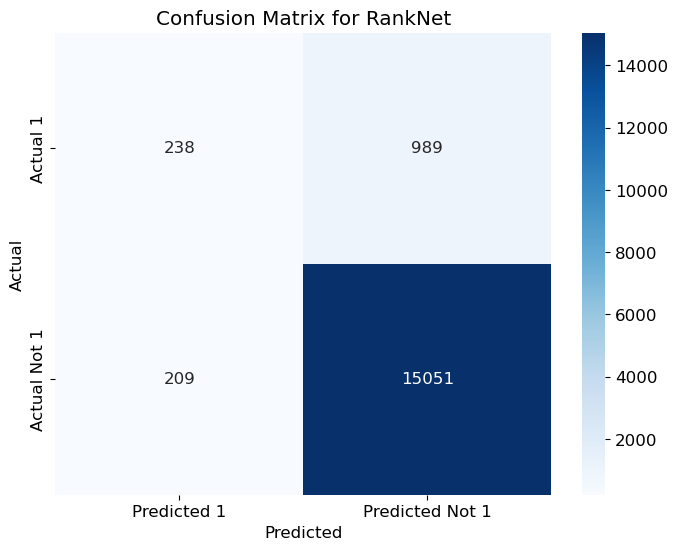

Precision for Pairwise: 0.4953
Recall for Pairwise: 0.1280
F1 Score for Pairwise: 0.2034


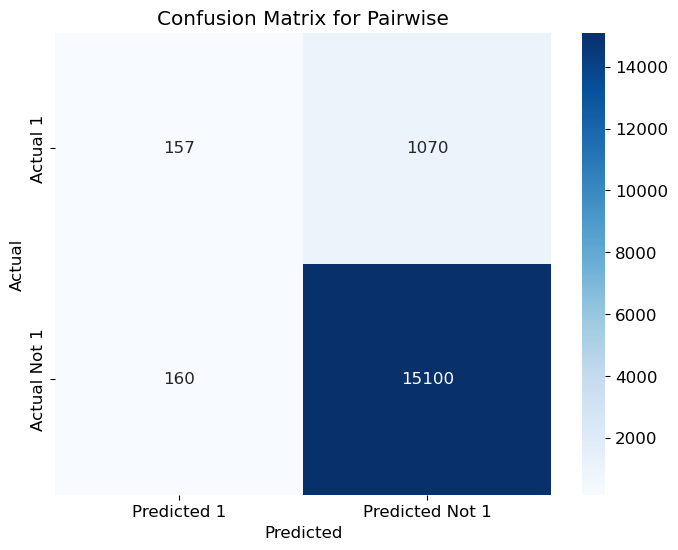

In [59]:
# 1位と2位のスコアの差を可視化する→閾値を決定してコンフュージョンマトリックスで正解率を確認する

# 1位と2位のスコアの差を算出
def calculate_score_diff(df, modelname):
    score_diff = []
    for race_id, group in df.groupby('race_id'):
        sorted_group = group.sort_values(f'予測スコア({modelname})', ascending=False)
        if len(sorted_group) >= 2:
            score_1 = sorted_group.iloc[0][f'予測スコア({modelname})']
            score_2 = sorted_group.iloc[1][f'予測スコア({modelname})']
            diff = score_1 - score_2
            score_diff.extend([diff] * len(group))
        else:
            score_diff.extend([None] * len(group))
    return score_diff

df_prediction_test_ranking['score_diff_lambdarank'] = calculate_score_diff(df_prediction_test_ranking, 'lambdarank')
df_prediction_test_ranking['score_diff_RankNet'] = calculate_score_diff(df_prediction_test_ranking, 'RankNet')
df_prediction_test_ranking['score_diff_Pairwise'] = calculate_score_diff(df_prediction_test_ranking, 'Pairwise')

# 1位が正解した時、2位だった時、それ以外だった時のスコアの差を可視化
def plot_score_diff(df, modelname):
    correct_1st = df[(df[f'予測順位({modelname})'] == 1) & (df['着順'] == 1)]
    second_place = df[(df[f'予測順位({modelname})'] == 1) & (df['着順'] == 2)]
    other_places = df[(df[f'予測順位({modelname})'] == 1) & (df['着順'] > 2)]

    plt.figure(figsize=(10, 6))
    sns.histplot(correct_1st[f'score_diff_{modelname}'], kde=True, color='green', label='Correct 1st', bins=50)
    sns.histplot(second_place[f'score_diff_{modelname}'], kde=True, color='blue', label='2nd Place', bins=50)
    sns.histplot(other_places[f'score_diff_{modelname}'], kde=True, color='red', label='Other Places', bins=50)
    plt.xlabel('Score Difference')
    plt.ylabel('Frequency')
    plt.title(f'Score Difference for {modelname}')
    plt.legend()
    plt.show()

plot_score_diff(df_prediction_test_ranking, 'lambdarank')
plot_score_diff(df_prediction_test_ranking, 'RankNet')
plot_score_diff(df_prediction_test_ranking, 'Pairwise')

from sklearn.metrics import roc_curve, precision_recall_curve

# 最適な閾値を見つける
def find_optimal_threshold(df, modelname):
    y_true = (df['着順'] == 1).astype(int)
    y_scores = df[f'score_diff_{modelname}']

    # ROC曲線を使用して最適な閾値を見つける
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Precision-Recall曲線を使用して最適な閾値を見つける
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * precision * recall / (precision + recall)
    optimal_idx_pr = np.argmax(f1_scores)
    optimal_threshold_pr = thresholds_pr[optimal_idx_pr]

    return optimal_threshold, optimal_threshold_pr

optimal_threshold_lambdarank, optimal_threshold_pr_lambdarank = find_optimal_threshold(df_prediction_test_ranking, 'lambdarank')
optimal_threshold_ranknet, optimal_threshold_pr_ranknet = find_optimal_threshold(df_prediction_test_ranking, 'RankNet')
optimal_threshold_pairwise, optimal_threshold_pr_pairwise = find_optimal_threshold(df_prediction_test_ranking, 'Pairwise')

print(f'Optimal Threshold (ROC) for lambdarank: {optimal_threshold_lambdarank}')
print(f'Optimal Threshold (Precision-Recall) for lambdarank: {optimal_threshold_pr_lambdarank}')
print(f'Optimal Threshold (ROC) for RankNet: {optimal_threshold_ranknet}')
print(f'Optimal Threshold (Precision-Recall) for RankNet: {optimal_threshold_pr_ranknet}')
print(f'Optimal Threshold (ROC) for Pairwise: {optimal_threshold_pairwise}')
print(f'Optimal Threshold (Precision-Recall) for Pairwise: {optimal_threshold_pr_pairwise}')

def apply_threshold(df, modelname, threshold):
    # 予測結果を閾値で分類
    # 予測スコアが閾値以上の場合かつ予測順位が1の時は1、それ以外は0
    df[f'予測結果({modelname})'] = ((df[f'score_diff_{modelname}'] >= threshold) & (df[f'予測順位({modelname})'] == 1)).astype(int)
    return df

df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'lambdarank', optimal_threshold_lambdarank)
df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'RankNet', optimal_threshold_ranknet)
df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'Pairwise', optimal_threshold_pairwise)

# 予測精度を評価し、Confusion Matrixを出力
def evaluate_predictions(df, modelname):
    true_positive = df[
        (df[f'予測結果({modelname})'] == 1) & 
        (df['着順'] == 1)
    ].shape[0]

    false_positive = df[
        (df[f'予測結果({modelname})'] == 1) & 
        (df['着順'] != 1)
    ].shape[0]

    false_negative = df[
        (df[f'予測結果({modelname})'] != 1) & 
        (df['着順'] == 1)
    ].shape[0]

    true_negative = df[
        (df[f'予測結果({modelname})'] != 1) & 
        (df['着順'] != 1)
    ].shape[0]

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f'Precision for {modelname}: {precision:.4f}')
    print(f'Recall for {modelname}: {recall:.4f}')
    print(f'F1 Score for {modelname}: {f1_score:.4f}')

    # Confusion Matrixの作成
    # Confusion Matrixの作成
    confusion_matrix = np.array([[true_positive, false_negative],
                                [false_positive, true_negative]])

    # Confusion Matrixの可視化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 1', 'Predicted Not 1'], yticklabels=['Actual 1', 'Actual Not 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {modelname}')
    plt.show()

evaluate_predictions(df_prediction_test_ranking, 'lambdarank')
evaluate_predictions(df_prediction_test_ranking, 'RankNet')
evaluate_predictions(df_prediction_test_ranking, 'Pairwise')

True Positive: 18
False Positive: 12
False Negative: 1209
True Negative: 15248
Precision for lambdarank: 0.6000
Recall for lambdarank: 0.0147
F1 Score for lambdarank: 0.0286


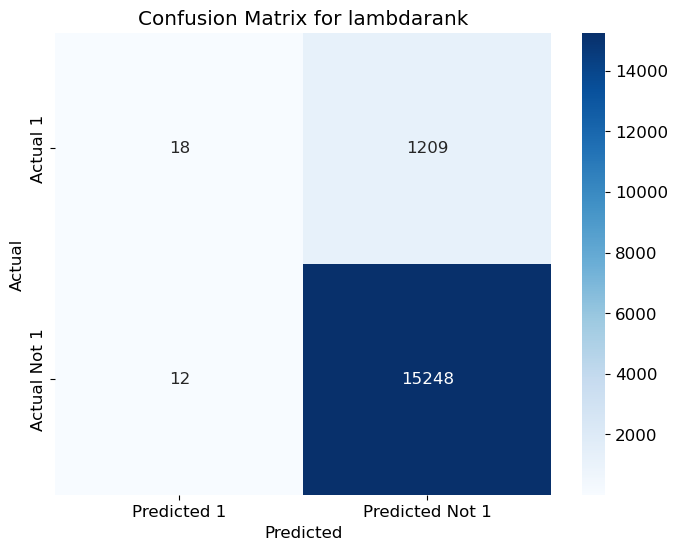

True Positive: 152
False Positive: 211
False Negative: 1075
True Negative: 15049
Precision for RankNet: 0.4187
Recall for RankNet: 0.1239
F1 Score for RankNet: 0.1912


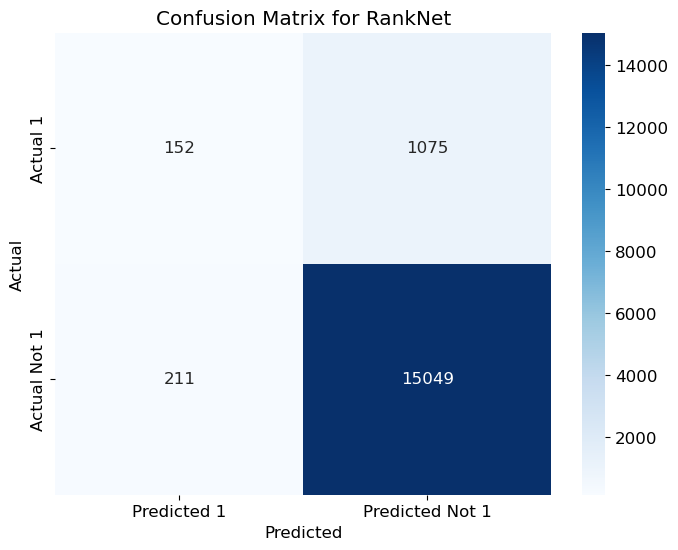

True Positive: 95
False Positive: 102
False Negative: 1132
True Negative: 15158
Precision for Pairwise: 0.4822
Recall for Pairwise: 0.0774
F1 Score for Pairwise: 0.1334


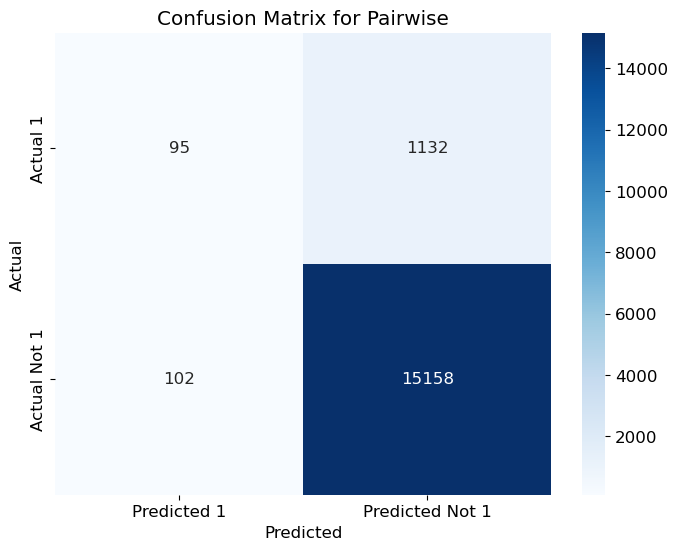

In [60]:
# 上の閾値はROC曲線からすべてのデータに対しての閾値を設定しているので、
# レースごとのスコアのばらつきを考慮して動的に閾値を調整する
# 各レースごとにスコアの標準偏差を計算
def calculate_standard_deviation(df, modelname):
    std_devs = df.groupby('race_id')[f'予測スコア({modelname})'].std()
    return std_devs

# 標準偏差を基に動的に閾値を調整
def adjust_thresholds(df, modelname, base_threshold):
    std_devs = calculate_standard_deviation(df, modelname)
    adjusted_thresholds = {}
    for race_id, std_dev in std_devs.items():
        adjusted_thresholds[race_id] = base_threshold + std_dev
    return adjusted_thresholds

# 調整された閾値を使用して予測を行う
def apply_adjusted_thresholds(df, modelname, adjusted_thresholds):
    df[f'予測結果({modelname})'] = df.apply(
        lambda row: 1 if row[f'予測スコア({modelname})'] >= adjusted_thresholds[row['race_id']] else 0,
        axis=1
    )
    return df

# 基本の閾値はROC曲線から求めたものを使用
# base_threshold_lambdarank = optimal_threshold_lambdarank
# base_threshold_ranknet = optimal_threshold_ranknet
# base_threshold_pairwise = optimal_threshold_pairwise

base_threshold_lambdarank = 0.5
base_threshold_ranknet = 0.5
base_threshold_pairwise = 0.5

# 各モデルの調整された閾値を計算
adjusted_thresholds_lambdarank = adjust_thresholds(df_prediction_test_ranking, 'lambdarank', base_threshold_lambdarank)
adjusted_thresholds_ranknet = adjust_thresholds(df_prediction_test_ranking, 'RankNet', base_threshold_ranknet)
adjusted_thresholds_pairwise = adjust_thresholds(df_prediction_test_ranking, 'Pairwise', base_threshold_pairwise)

# 調整された閾値を適用して予測を行う
df_prediction_test_ranking = apply_adjusted_thresholds(df_prediction_test_ranking, 'lambdarank', adjusted_thresholds_lambdarank)
df_prediction_test_ranking = apply_adjusted_thresholds(df_prediction_test_ranking, 'RankNet', adjusted_thresholds_ranknet)
df_prediction_test_ranking = apply_adjusted_thresholds(df_prediction_test_ranking, 'Pairwise', adjusted_thresholds_pairwise)

# 予測精度を評価し、Confusion Matrixを出力
def evaluate_predictions(df, modelname):
    true_positive = df[
        (df[f'予測結果({modelname})'] == 1) & 
        (df['着順'] == 1)
    ].shape[0]

    false_positive = df[
        (df[f'予測結果({modelname})'] == 1) & 
        (df['着順'] != 1)
    ].shape[0]

    false_negative = df[
        (df[f'予測結果({modelname})'] != 1) & 
        (df['着順'] == 1)
    ].shape[0]

    true_negative = df[
        (df[f'予測結果({modelname})'] != 1) & 
        (df['着順'] != 1)
    ].shape[0]
    print(f'True Positive: {true_positive}')
    print(f'False Positive: {false_positive}')
    print(f'False Negative: {false_negative}')
    print(f'True Negative: {true_negative}')

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f'Precision for {modelname}: {precision:.4f}')
    print(f'Recall for {modelname}: {recall:.4f}')
    print(f'F1 Score for {modelname}: {f1_score:.4f}')

    # Confusion Matrixの作成
    confusion_matrix = np.array([[true_positive, false_negative],
                                [false_positive, true_negative]])

    # Confusion Matrixの可視化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 1', 'Predicted Not 1'], yticklabels=['Actual 1', 'Actual Not 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {modelname}')
    plt.show()

evaluate_predictions(df_prediction_test_ranking, 'lambdarank')
evaluate_predictions(df_prediction_test_ranking, 'RankNet')
evaluate_predictions(df_prediction_test_ranking, 'Pairwise')

In [61]:
# # 条件によらず結果はほぼ一緒

# # 予測結果に対して距離、天気、馬場状態、コースの特長量ごとに予測精度が変わらないかを可視化する。
# # 評価対象は予測結果なので、一位と二位の差分のやつも入ってる。
# # 予測結果は1位は1、それ以外は0に対して着順は順位になっているので、順位を1位だけ1、それ以外を0とする新たな列を作成
# # df_prediction_test_ranking['着順_01'] = df_prediction_test_ranking['着順'].apply(lambda x: 1 if x == 1 else 0)

# # 予測結果の評価を行う関数
# def evaluate_predictions(df, modelname):
#     # TP, FP, FN, TNを計算
#     true_positive = df[
#         (df[f'予測結果({modelname})'] == 1) & 
#         (df['着順'] == 1)
#     ].shape[0]

#     false_positive = df[
#         (df[f'予測結果({modelname})'] == 1) &
#         (df['着順'] == 0)
#     ].shape[0]

#     false_negative = df[
#         (df[f'予測結果({modelname})'] == 0) &
#         (df['着順'] == 1)
#     ].shape[0]

#     true_negative = df[
#         (df[f'予測結果({modelname})'] == 0) &
#         (df['着順'] == 0)
#     ].shape[0]

#     # Precision, Recallを計算
#     precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
#     recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

#     return precision, recall

# # 各特長量ごとにデータを分類して評価
# def evaluate_by_feature(df, feature, modelname):
#     unique_values = df[feature].unique()
#     results = []
#     for value in unique_values:
#         subset = df[df[feature] == value]
#         precision, recall = evaluate_predictions(subset, modelname)
#         results.append((value, precision, recall))
#     return results

# # 評価結果をデータフレームにまとめる
# def results_to_dataframe(results, feature_name):
#     df = pd.DataFrame(results, columns=[feature_name, 'precision', 'Recall'])
#     return df

# # 棒グラフで可視化
# def plot_results(df, feature_name,modelname):
#     df_melted = df.melt(id_vars=[feature_name], value_vars=['precision', 'Recall'], var_name='Metric', value_name='Score')
#     plt.figure(figsize=(12, 6))
#     sns.barplot(x=feature_name, y='Score', hue='Metric', data=df_melted)
#     plt.title(f'precision and Recall by {feature_name}, {modelname}')
#     plt.xticks(rotation=45)
#     plt.show()

# def model_evaluation_by_feature(df, modelname):
#     # 各特長量ごとに評価
#     distance_results = evaluate_by_feature(df_prediction_test_ranking, 'distance', modelname)
#     condition_results = evaluate_by_feature(df_prediction_test_ranking, 'condition', modelname)
#     weather_results = evaluate_by_feature(df_prediction_test_ranking, 'weather', modelname)
#     ground_state_results = evaluate_by_feature(df_prediction_test_ranking, 'ground_state', modelname)

#     distance_df = results_to_dataframe(distance_results, 'Distance')
#     condition_df = results_to_dataframe(condition_results, 'Condition')
#     weather_df = results_to_dataframe(weather_results, 'Weather')
#     ground_state_df = results_to_dataframe(ground_state_results, 'Ground State')
            

#     plot_results(distance_df, 'Distance',modelname)
#     plot_results(condition_df, 'Condition',modelname)
#     plot_results(weather_df, 'Weather',modelname)
#     plot_results(ground_state_df, 'Ground State',modelname)

# model_evaluation_by_feature(df_prediction_test_ranking, 'lambdarank')
# model_evaluation_by_feature(df_prediction_test_ranking, 'RankNet')
# model_evaluation_by_feature(df_prediction_test_ranking, 'Pairwise')

In [76]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# コンフュージョンマトリックスを生成する関数
def generate_confusion_matrix(df, modelname):
    y_true = []
    y_pred = []
    
    for race_id, group in df.groupby('race_id'):
        print(race_id)
        # 予測結果の1位と2位の馬を抽出
        predicted_top2 = set(group.nsmallest(2, modelname)['馬番号'].values)
        print("predicted_top2",predicted_top2)
        # 実際のレース結果の1位と2位の馬を抽出
        actual_top2 = set(group.nsmallest(2, '着順')['馬番号'].values)
        print("actual_top2",actual_top2)
        # 予測結果と実際のレース結果を比較して一致しているかを判断しているのがここ。
        y_true.append(1 if actual_top2 == predicted_top2 else 0)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    print(y_true)
    
    # すべてのレースのうちの予測的中率
    sum_ = len(y_true)
    print(sum_)
    y_true_total = np.sum(y_true == 1)
    print(y_true_total)
    print("precision rate {}".format(y_true_total / sum_))
    
    

# 各モデルに対してコンフュージョンマトリックスを生成
models = ['予測順位(lambdarank)', '予測順位(Pairwise)', '予測順位(RankNet)']
for model in models:
    generate_confusion_matrix(df_prediction_test_ranking, model)

202407030407
predicted_top2 {13, 7}
actual_top2 {11, 5}
202407030408
predicted_top2 {4, 5}
actual_top2 {4, 5}
202407030409
predicted_top2 {8, 2}
actual_top2 {8, 2}
202407030410
predicted_top2 {16, 8}
actual_top2 {2, 4}
202407030411
predicted_top2 {3, 15}
actual_top2 {2, 4}
202407030412
predicted_top2 {2, 12}
actual_top2 {2, 4}
202407030501
predicted_top2 {4, 6}
actual_top2 {9, 4}
202407030502
predicted_top2 {10, 6}
actual_top2 {10, 4}
202407030503
predicted_top2 {9, 5}
actual_top2 {8, 5}
202407030504
predicted_top2 {4, 12}
actual_top2 {1, 4}
202407030505
predicted_top2 {11, 12}
actual_top2 {11, 12}
202407030506
predicted_top2 {12, 15}
actual_top2 {14, 15}
202407030507
predicted_top2 {9, 6}
actual_top2 {9, 6}
202407030508
predicted_top2 {2, 6}
actual_top2 {2, 7}
202407030509
predicted_top2 {8, 9}
actual_top2 {9, 5}
202407030510
predicted_top2 {2, 7}
actual_top2 {3, 7}
202407030511
predicted_top2 {2, 15}
actual_top2 {2, 11}
202407030512
predicted_top2 {8, 11}
actual_top2 {8, 11}
20240703

In [64]:
# 特徴重要度の可視化
df_importance = pd.DataFrame({"columns": X_sorted_train_data.columns, "importance": model.feature_importances_})
df_importance.sort_values("importance", ascending=False, inplace=True)
print(df_importance)

AttributeError: 'str' object has no attribute 'feature_importances_'

In [63]:
# カレントディレクトリにモデルを保存
import pickle
with open('lambdarank_model.pkl', 'wb') as f:
    pickle.dump(model, f)
# カレントディレクトリにranknet_modelモデルを保存
with open('ranknet_model.pkl', 'wb') as f:
    pickle.dump(ranknet_model, f)
# カレントディレクトリにpairwise_modelモデルを保存
with open('pairwise_model.pkl', 'wb') as f:
    pickle.dump(pairwise_model, f)

In [64]:
# オッズの差分を計算して新しい特徴量として追加
def add_odds_differences_for_inference(df):
    sorted_df = df.sort_values('odds')
    if len(sorted_df) >= 3:
        odds_1 = sorted_df.iloc[0]['odds']
        odds_2 = sorted_df.iloc[1]['odds']
        odds_3 = sorted_df.iloc[2]['odds']
        df['odds_diff-1-2'] = odds_1 - odds_2
        df['odds_diff-1-3'] = odds_1 - odds_3
    else:
        df['odds_diff-1-2'] = None
        df['odds_diff-1-3'] = None
    return df


In [65]:
from pathlib import Path
import pandas as pd
import tqdm

# 青色で出力
# "RankNetの正答率が高い"
print("\033[34mRankNetの正答率が高い\033[0m")

# csvデータを1つずつ読み出し推論
p = Path(inference_data_path)
files = list(p.glob("*inference*.csv"))
print(p)
print(files)
count = 0
for file in tqdm.tqdm(files):
    # 読み込んだファイル名を出力
    # print("=======予測ファイル名======== {}".format(file))
    print("=======予測ファイル名========\n {}".format(file))
    inference_data = pd.read_csv(file, encoding='utf-8')
    # データの確認
    # print(inference_data.info())

    # Unnamed: 0,class_list_in_raceを削除
    # inference_data = inference_data.drop(['Unnamed: 0',"class_list_in_race","date"], axis=1)
    # inference_data.info()

    #　=================real dataで推論=============================
    inference_data_answer = inference_data["goal_number"]
    inference_data = inference_data.drop("goal_number", axis=1)

    # 学習データとカラム名を統一する
    # 枠 番は枠番に変換する
    inference_data = inference_data.rename(columns={'枠 番':'枠番'})
    # 馬 番は馬番に変換する
    inference_data = inference_data.rename(columns={'馬 番':'馬番'})
    # 人 気は人気に変換する
    inference_data = inference_data.rename(columns={'人 気':'人気'})
    # 斤 量は斤量に変換する
    inference_data = inference_data.rename(columns={'斤 量':'斤量'})
    # タイムはタイム_yに変換する
    inference_data = inference_data.rename(columns={'タイム':'タイム_y'})
    # 天 気は天気に変換する
    inference_data = inference_data.rename(columns={'天 気':'天気'})
    # 頭 数は頭数に変換する
    inference_data = inference_data.rename(columns={'頭 数':'頭数'})
    # オ ッ ズ はオッズに変換する
    inference_data = inference_data.rename(columns={'オ ッ ズ':'オッズ'})
    # 馬 場は馬場に変換する
    inference_data = inference_data.rename(columns={'馬 場':'馬場'})
    # 騎乗 回数は騎乗回数に変換する
    inference_data = inference_data.rename(columns={'騎乗 回数':'騎乗回数'})
    # 重賞 出走は重賞出走に変換する
    inference_data = inference_data.rename(columns={'重賞 出走':'重賞出走'})
    # 重賞 勝利は重賞勝利に変換する
    inference_data = inference_data.rename(columns={'重賞 勝利':'重賞勝利'})

    # 学習データとの共通処理
    # タイム_yは1:34.0のような形式なので、秒に変換する
    # nanの場合は100に変換する
    # 'タイム_y'列の値を文字列に変換し、NaN値を無視して処理を行う
    inference_data['タイム_y'] = inference_data['タイム_y'].astype(str).apply(
        lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if ':' in x else np.nan
    )

    # 'ペース'列の値を文字列に変換し、NaN値を無視して処理を行う
    inference_data['pace1'] = inference_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[0]) if '-' in x else np.nan
    )
    inference_data['pace2'] = inference_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[1]) if '-' in x else np.nan
    )

    # 馬体重_yは480(+2)のような形式なので、体重と増減を分ける
    # '馬体重'列の値を文字列に変換し、'計不'を'500(0)'に置き換える
    inference_data['馬体重'] = inference_data['馬体重'].astype(str).replace('計不', '500(0)')

    # 'horse_weight_y'列を作成し、'馬体重'列の値を処理
    inference_data['horse_weight_y'] = inference_data['馬体重'].apply(
        lambda x: int(x.split('(')[0]) if '(' in x else np.nan
    )

    # 'weight_change_y'列を作成し、'馬体重'列の値を処理
    inference_data['weight_change_y'] = inference_data['馬体重'].apply(
        lambda x: int(x.split('(')[1].replace(')', '')) if '(' in x else np.nan
    )

    # '連対率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    # ％しかない場合は暫定で0％に変換する
    # '連対率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['連対率'] = inference_data['連対率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) and x.strip() != '' else 0.0
    )

    # '勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['勝率'] = inference_data['勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) and x.strip() != '' else 0.0
    )
    
    # '複勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['複勝率'] = inference_data['複勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) and x.strip() != '' else 0.0
    )
    # 1/オッズを計算して新しい特徴量として追加
    inference_data['odds_inv'] = 1 / inference_data['オッズ']

    # クエリを使用してオッズの特長量をエンジニアリング
    # 1 オッズを対数変換
    inference_data["log_odds"] = np.log1p(inference_data["odds"])

    # 2 同一レースidにおけるオッズのmin-max正規化
    inference_data["normalized_odds"] = (inference_data["odds"] - inference_data["odds"].min()) / (inference_data["odds"].max() - inference_data["odds"].min())
    # 3 zスコア標準化
    inference_data["zscore_odds"] = (inference_data["odds"] - inference_data["odds"].mean()) / inference_data["odds"].std()

    # 4オッズの順位
    inference_data["odds_rank"] = inference_data["odds"].rank(ascending=False)

    # 5 レースごとのオッズのばらつき
    inference_data["odds_std"] = inference_data["odds"].std()

    inference_data_odds = inference_data["odds"]

    # odds_inv = 1 / inference_data["odds"]
    inference_data["1/オッズ"] = 1 / inference_data["odds"]

    # 前処理用の適当なrace_idを追加
    inference_data_race_id = ["test"] * len(inference_data)
    # オッズの差分を計算して新しい特徴量として追加
    inference_data = add_odds_differences_for_inference(inference_data)
    

    # X_sorted_train_data.columnsの日本語文字列の半角、全角スペースを削除する
    X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace(' ', '')
    X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace('　', '')
    

    # inference_dataの特長量を設定する
    inference_data = inference_data[X_sorted_train_data.columns]

    # ラベルエンコーディングは前処理終了後
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = inference_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        inference_data[column] = le.fit_transform(inference_data[column])

    # 対数変換実施
    # inference_data = log_transform(inference_data)

    # 標準化実施
    # inference_data = standard_scaler(inference_data)

    # モデル予測
    prediction_inference_ranking = model.predict(inference_data, num_iteration=model.best_iteration_)
    prediction_inference_ranking_ranknet = ranknet_model.predict(inference_data)
    prediction_inference_ranking_pairwise = pairwise_model.predict(inference_data)
    # シンプルに予測結果の平均を取る
    prediction_inference = (prediction_inference_ranking + prediction_inference_ranking_ranknet + prediction_inference_ranking_pairwise) / 3
    # データフレームを作成
    df_prediction_test_ranking = pd.DataFrame({
        "horse_id": inference_data["umaban"],
        "予測スコア(lambdarank)": prediction_inference_ranking,
        "予測スコア(RankNet)": prediction_inference_ranking_ranknet,
        "予測スコア(Pairwise)": prediction_inference_ranking_pairwise,
        "predict_amsamble": prediction_inference,
        "odds": inference_data_odds,
        "goal": inference_data_answer,
        "race_id": inference_data_race_id
    })

    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア(lambdarank)", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking["予測スコア(lambdarank)"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア(RankNet)", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking["予測スコア(RankNet)"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア(Pairwise)", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking["予測スコア(Pairwise)"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="predict_amsamble", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(amsamble)"] = df_prediction_test_ranking["predict_amsamble"].rank(ascending=False, method='first').astype(int)
    # インデックスをリセット
    df_prediction_test_ranking = df_prediction_test_ranking.reset_index(drop=True)
    # 最後に着順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="goal")

    # 結果を確認
    # print(df_prediction_test_ranking.head())
    # pandasをcsvに保存
    # inference_data_path + /inference_resultにディレクトリを作成し、csvを保存する
    inference_data_path_result = inference_data_path + "inference_result/"
    if not os.path.isdir(inference_data_path_result):
        os.mkdir(inference_data_path_result)
    file_name = file.name
    saving_path = inference_data_path_result + "prediction_" +  str(file_name) + "_.csv"
    # print("saving_path:{}".format(saving_path))
    df_prediction_test_ranking.to_csv(saving_path, index=False)

    # 推論データに対して予測を行う。1位と2位のスコアの差を計算し、閾値を適用して各モデルごとに1位を予測する
    # 予測スコアの差を計算
    df_prediction_test_ranking['score_diff_lambdarank'] = calculate_score_diff(df_prediction_test_ranking, 'lambdarank')
    df_prediction_test_ranking['score_diff_RankNet'] = calculate_score_diff(df_prediction_test_ranking, 'RankNet')
    df_prediction_test_ranking['score_diff_Pairwise'] = calculate_score_diff(df_prediction_test_ranking, 'Pairwise')
    # 閾値を適用して1位を予測
    df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'lambdarank', optimal_threshold_lambdarank)
    df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'RankNet', optimal_threshold_ranknet)
    df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'Pairwise', optimal_threshold_pairwise)

    # 予測結果{modelname}の中で1がある場合はその情報を出力
    if df_prediction_test_ranking['予測結果(lambdarank)'].sum() > 0:
        print(f'\033[92m1位と予測した数(lambdarank): {df_prediction_test_ranking["予測結果(lambdarank)"].sum()}\033[0m')
        print(df_prediction_test_ranking[df_prediction_test_ranking['予測結果(lambdarank)'] == 1])
        # その時のほかモデルの1位と2位のスコアの差と閾値を出力
        print(f'RankNet:1位と予測した時の2位とのスコアの差: {df_prediction_test_ranking["score_diff_RankNet"].values[0]}')
        print(f'RankNet:閾値: {optimal_threshold_ranknet}')
        print(f'Pairwise:1位と予測した時の2位とのスコアの差: {df_prediction_test_ranking["score_diff_Pairwise"].values[0]}')
        print(f'Pairwise:閾値: {optimal_threshold_pairwise}')

    if df_prediction_test_ranking['予測結果(RankNet)'].sum() > 0:
        print(f'\033[94m1位と予測した数(RankNet): {df_prediction_test_ranking["予測結果(RankNet)"].sum()}\033[0m')
        print(df_prediction_test_ranking[df_prediction_test_ranking['予測結果(RankNet)'] == 1])
        # その時のほかモデルの1位と2位のスコアの差と閾値を出力
        print(f'lambdarank:1位と予測した時の2位とのスコアの差: {df_prediction_test_ranking["score_diff_lambdarank"].values[0]}')
        print(f'lambdarank:閾値: {optimal_threshold_lambdarank}')
        print(f'Pairwise:1位と予測した時の2位とのスコアの差: {df_prediction_test_ranking["score_diff_Pairwise"].values[0]}')
        print(f'Pairwise:閾値: {optimal_threshold_pairwise}')

    if df_prediction_test_ranking['予測結果(Pairwise)'].sum() > 0:
        print(f'\033[93m1位と予測した数(Pairwise): {df_prediction_test_ranking["予測結果(Pairwise)"].sum()}\033[0m')
        print(df_prediction_test_ranking[df_prediction_test_ranking['予測結果(Pairwise)'] == 1])
        # その時のほかモデルの1位と2位のスコアの差と閾値を出力
        print(f'lambdarank:1位と予測した時の2位とのスコアの差: {df_prediction_test_ranking["score_diff_lambdarank"].values[0]}')
        print(f'lambdarank:閾値: {optimal_threshold_lambdarank}')   
        print(f'RankNet:1位と予測した時の2位とのスコアの差: {df_prediction_test_ranking["score_diff_RankNet"].values[0]}')
        print(f'RankNet:閾値: {optimal_threshold_ranknet}')

    # =================================================================
    # 予測結果がシビアすぎて全然買い目が出ないので過去の情報も一応出力しておく
    # =================================================================
    # すべてのモデルのスコアが正で1位かつスコアが0以上のものをフィルタリング
    buy_candidates_all_positive = df_prediction_test_ranking[
        (df_prediction_test_ranking["予測順位(lambdarank)"] == 1) &
        (df_prediction_test_ranking["予測順位(RankNet)"] == 1) &
        (df_prediction_test_ranking["予測順位(Pairwise)"] == 1) &
        (df_prediction_test_ranking["予測スコア(lambdarank)"] > 0) &
        (df_prediction_test_ranking["予測スコア(RankNet)"] > 0) &
        (df_prediction_test_ranking["予測スコア(Pairwise)"] > 0)
    ]

    # 1つのモデルのスコアがマイナスでも他のモデルのスコアが0以上で1着のものをフィルタリング
    buy_candidates_one_negative = df_prediction_test_ranking[
        ((df_prediction_test_ranking['予測順位(lambdarank)'] == 1) & (df_prediction_test_ranking['予測スコア(lambdarank)'] > 0) &
        (df_prediction_test_ranking['予測順位(Pairwise)'] == 1) & (df_prediction_test_ranking['予測スコア(Pairwise)'] > 0) &
        (df_prediction_test_ranking['予測順位(RankNet)'] == 1) & (df_prediction_test_ranking['予測スコア(RankNet)'] <= 0)) |
        ((df_prediction_test_ranking['予測順位(lambdarank)'] == 1) & (df_prediction_test_ranking['予測スコア(lambdarank)'] > 0) &
        (df_prediction_test_ranking['予測順位(Pairwise)'] == 1) & (df_prediction_test_ranking['予測スコア(Pairwise)'] <= 0) &
        (df_prediction_test_ranking['予測順位(RankNet)'] == 1) & (df_prediction_test_ranking['予測スコア(RankNet)'] > 0)) |
        ((df_prediction_test_ranking['予測順位(lambdarank)'] == 1) & (df_prediction_test_ranking['予測スコア(lambdarank)'] <= 0) &
        (df_prediction_test_ranking['予測順位(Pairwise)'] == 1) & (df_prediction_test_ranking['予測スコア(Pairwise)'] > 0) &
        (df_prediction_test_ranking['予測順位(RankNet)'] == 1) & (df_prediction_test_ranking['予測スコア(RankNet)'] > 0))
    ]

    # スコアがすべて正のとき1つのモデルの順位が1でない場合をフィルタリング
    buy_candidates_one_not_first = df_prediction_test_ranking[
        ((df_prediction_test_ranking['予測順位(lambdarank)'] == 1) & (df_prediction_test_ranking['予測スコア(lambdarank)'] > 0) &
        (df_prediction_test_ranking['予測順位(Pairwise)'] == 1) & (df_prediction_test_ranking['予測スコア(Pairwise)'] > 0) &
        (df_prediction_test_ranking['予測順位(RankNet)'] != 1) & (df_prediction_test_ranking['予測スコア(RankNet)'] > 0)) |
        ((df_prediction_test_ranking['予測順位(lambdarank)'] == 1) & (df_prediction_test_ranking['予測スコア(lambdarank)'] > 0) &
        (df_prediction_test_ranking['予測順位(Pairwise)'] != 1) & (df_prediction_test_ranking['予測スコア(Pairwise)'] > 0) &
        (df_prediction_test_ranking['予測順位(RankNet)'] == 1) & (df_prediction_test_ranking['予測スコア(RankNet)'] > 0)) |
        ((df_prediction_test_ranking['予測順位(lambdarank)'] != 1) & (df_prediction_test_ranking['予測スコア(lambdarank)'] > 0) &
        (df_prediction_test_ranking['予測順位(Pairwise)'] == 1) & (df_prediction_test_ranking['予測スコア(Pairwise)'] > 0) &
        (df_prediction_test_ranking['予測順位(RankNet)'] == 1) & (df_prediction_test_ranking['予測スコア(RankNet)'] > 0))
    ]
    # 買い目として出力
    # if not buy_candidates_all_positive.empty:
    #     print("Buy candidates (all positive scores and all ranks 1):")
    #     print(buy_candidates_all_positive)
    # elif not buy_candidates_one_negative.empty:
    #     print("Buy candidates (one negative score but all ranks 1):")
    #     print(buy_candidates_one_negative)
    # elif not buy_candidates_one_not_first.empty:
    #     print("Buy candidates (all positive scores but one rank not 1):")
    #     print(buy_candidates_one_not_first)
    # else:
    #     print("No buy candidates found.")

    count +=1


RankNetの正答率が高い
/home/hayato/horse_inference/inference/2025050108/add_dynamic_data
[PosixPath('/home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_20250501087.csv'), PosixPath('/home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_202505010810.csv'), PosixPath('/home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_202505010811.csv'), PosixPath('/home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_20250501081.csv'), PosixPath('/home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_20250501085.csv'), PosixPath('/home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_202505010812.csv'), PosixPath('/home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_20250501088.csv'), PosixPath('/home/hayato/horse_inference/inference/2025050108/add_dynamic_d

  0%|          | 0/9 [00:00<?, ?it/s]

=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_20250501087.csv
[LightGBM] [Warning] Unknown parameter: max_position


 22%|██▏       | 2/9 [00:00<00:00, 17.01it/s]

1位と予測した数(RankNet): 1
   horse_id  予測スコア(lambdarank)  予測スコア(RankNet)  予測スコア(Pairwise)   
0         1           0.344947        1.151191        -1.141753  \

   predict_amsamble  odds  goal race_id  予測順位(lambdarank)  予測順位(RankNet)   
0          0.118128   5.8   NaN    test                 1              1  \

   予測順位(Pairwise)  予測順位(amsamble)  score_diff_lambdarank  score_diff_RankNet   
0               4               1               0.345116            1.393638  \

   score_diff_Pairwise  予測結果(lambdarank)  予測結果(RankNet)  予測結果(Pairwise)  
0             0.178723                 0              1               0  
lambdarank:1位と予測した時の2位とのスコアの差: 0.34511571488983345
lambdarank:閾値: 0.6776001076416549
Pairwise:1位と予測した時の2位とのスコアの差: 0.1787230670452118
Pairwise:閾値: 2.328358232975006
=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_202505010810.csv
[LightGBM] [Warning] Unknown parameter: max_position
=======予測ファイル名========
 /home/haya

 44%|████▍     | 4/9 [00:00<00:00, 17.50it/s]

1位と予測した数(RankNet): 1
   horse_id  予測スコア(lambdarank)  予測スコア(RankNet)  予測スコア(Pairwise)   
0        10          -3.422954        1.309267        -3.581926  \

   predict_amsamble  odds  goal race_id  予測順位(lambdarank)  予測順位(RankNet)   
0         -1.898538   NaN   NaN    test                 9              1  \

   予測順位(Pairwise)  予測順位(amsamble)  score_diff_lambdarank  score_diff_RankNet   
0               8               1               0.012764            1.085789  \

   score_diff_Pairwise  予測結果(lambdarank)  予測結果(RankNet)  予測結果(Pairwise)  
0             0.003497                 0              1               0  
lambdarank:1位と予測した時の2位とのスコアの差: 0.012763546524195757
lambdarank:閾値: 0.6776001076416549
Pairwise:1位と予測した時の2位とのスコアの差: 0.003497004508972168
Pairwise:閾値: 2.328358232975006
=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_20250501085.csv
[LightGBM] [Warning] Unknown parameter: max_position
=======予測ファイル名========
 /home/ha

 67%|██████▋   | 6/9 [00:00<00:00, 18.54it/s]

[LightGBM] [Warning] Unknown parameter: max_position
1位と予測した数(RankNet): 1
   horse_id  予測スコア(lambdarank)  予測スコア(RankNet)  予測スコア(Pairwise)   
2        10          -2.884564        1.728306         0.096782  \

   predict_amsamble  odds  goal race_id  予測順位(lambdarank)  予測順位(RankNet)   
2         -0.353159  60.8   NaN    test                12              1  \

   予測順位(Pairwise)  予測順位(amsamble)  score_diff_lambdarank  score_diff_RankNet   
2               5               3                0.32563            1.977247  \

   score_diff_Pairwise  予測結果(lambdarank)  予測結果(RankNet)  予測結果(Pairwise)  
2             0.743085                 0              1               0  
lambdarank:1位と予測した時の2位とのスコアの差: 0.3256298764640818
lambdarank:閾値: 0.6776001076416549
Pairwise:1位と予測した時の2位とのスコアの差: 0.7430851459503174
Pairwise:閾値: 2.328358232975006
=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025050108/add_dynamic_data/updated_inference_data_20250501088.csv
[LightGBM] [Warning] Unknown paramet

100%|██████████| 9/9 [00:00<00:00, 19.38it/s]
